In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

#from torch.utils.tensorboard import SummaryWriter

import sklearn
import functools
import operator

import sys

sys.path.insert(1,"/home/sbulusu/qcd_ml/neural_networks/libs/")

import dataset_class_gsimage
import aenc_torch_net_class
#import aenc_utils
import utils

from tqdm.notebook import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Utilizing CUDA")
else:
    device = torch.device("cpu")
    print("Utilizing CPU")
    
cpu_device = torch.device("cpu")

Utilizing CUDA


In [3]:
"""Download dataset provided by pytorch"""
"""
from torchvision import datasets, transforms
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
"""

"\nfrom torchvision import datasets, transforms\n# MNIST Dataset\ntransform = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Normalize(mean=[0.5], std=[0.5])])\n\ntrain_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)\ntest_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)\n\n# Data Loader (Input Pipeline)\ntrain_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)\ntest_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)\n"

In [4]:
"""
plt.rcParams['figure.figsize'] = [20, 5]
n_load = 10
i = 0

fig, ax = plt.subplots(1,n_load)
for i in range(n_load):
    ax[i].imshow(train_dataset[i][0].detach().cpu().numpy().reshape([28,28]))
#plt.show()
#print(dataset.get_image(i)[1])
"""

"\nplt.rcParams['figure.figsize'] = [20, 5]\nn_load = 10\ni = 0\n\nfig, ax = plt.subplots(1,n_load)\nfor i in range(n_load):\n    ax[i].imshow(train_dataset[i][0].detach().cpu().numpy().reshape([28,28]))\n#plt.show()\n#print(dataset.get_image(i)[1])\n"

In [5]:
"""...But we will be using our custom dataset and functions!"""

#mnist_image_folder = "../data/mnist/"
#folder of the dataset
mnist_image_folder = "/media/data/sbulusu/datasets/mnist/mnist_images/"
mnist_image_names = os.listdir(mnist_image_folder)
#relative paths of all images to mnist_image_folder
mnist_image_paths = glob.glob("mnist/*")
image_size = [1,28,28]
#label_path_csv = "../data/mnist_labels.csv"
label_path_csv = "/media/data/sbulusu/datasets/mnist/mnist_labels.csv"
dataset = dataset_class_gsimage.image_dataset(mnist_image_folder, mnist_image_paths, image_size, label_path_csv, transform="default", device=device)
#dataset = dataset_class_gsimage.image_dataset(mnist_image_folder, mnist_image_paths, image_size, label_path_csv, transform=None, device=device)
#name of the attribute in the csv file
target_attributes = ["number"]
dataset.set_label_names(target_attributes)

['number']

In [6]:
dataset.transform = torchvision.transforms.Compose([
                dataset_class_gsimage.send_to_device(target_device=cpu_device),
                #dataset_class_gsimage.numpy(typ=np.uint8),
                dataset_class_gsimage.torch_tensor(typ=torch.uint8),
                #dataset_class_gsimage.roll_channel_axis(old_pos=0, new_pos=-1, device=torch.device("cpu")),
                torchvision.transforms.ToPILImage(mode=None),
                torchvision.transforms.RandomResizedCrop(size=(28,28),scale=(0.8, 1.0), ratio=(0.75, 1.33333), interpolation=2),
                torchvision.transforms.RandomRotation((-30,+30), resample=False, expand=False, center=None),
                torchvision.transforms.ToTensor(),
                dataset_class_gsimage.send_to_device(target_device=device),
                dataset_class_gsimage.min_max_scaler(device=device),
                torchvision.transforms.Normalize(mean=[0.5], std=[0.5]),
                torchvision.transforms.RandomApply([dataset_class_gsimage.add_normal_noise(0.,0.1,device=device)], p=0.5),
                torchvision.transforms.RandomErasing(p=0.5, scale=(0.01, 0.05), ratio=(0.3, 3.3), value=0, inplace=False)
            ])

/home/sbulusu/qcd_ml/neural_networks/libs/dataset_class_gsimage.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor.clone(), dtype=self.typ)


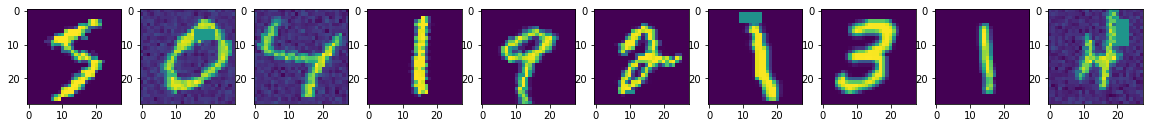

In [7]:
plt.rcParams['figure.figsize'] = [20, 5]
n_load = 10
i = 0

fig, ax = plt.subplots(1,n_load)
for i in range(n_load):
    ax[i].imshow(dataset.get_image(i)[0].detach().cpu().numpy().reshape([28,28]))
#plt.show()
#print(dataset.get_image(i)[1])

In [8]:
dataset.transform = torchvision.transforms.Compose([
                dataset_class_gsimage.min_max_scaler(device=device),
                torchvision.transforms.Normalize(mean=[0.0], std=[1.0]),
                #torchvision.transforms.RandomApply([dataset_class_gsimage.add_normal_noise(0.,0.1,device=device)], p=0.5),
                #torchvision.transforms.RandomErasing(p=0.5, scale=(0.01, 0.05), ratio=(0.3, 3.3), value=0, inplace=False)
            ])

In [9]:

"""Manually set network structure"""
"""
    This list can be loaded into the constructor of the Net neural network class, to automatically generate the network structure
    type = pointer to the layer function'
    layer_pars = parameters which must be given to the layer function in order to initialize it
    act_func = activation function to be applied directly after feeding to the corresponding layer
    dropout = certain neurons cna be dropped out if specified
"""

input_size = dataset.get_input_size()
output_size = input_size

latent_size = 10

fc_input_size = np.product(input_size)
print(fc_input_size)

784


In [10]:
act_func = torch.relu
#act_func = F.leaky_relu
#act_func = torch.sigmoid

encoder_struct = []
encoder_struct.append( {"type": nn.Flatten, "layer_pars": {"start_dim": 1}} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size, "out_features": fc_input_size//4}, "bias": True, "act_func": act_func} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//4, "out_features": fc_input_size//8}, "bias": True, "act_func": act_func} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//8, "out_features": fc_input_size//16}, "bias": True, "act_func": act_func} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//16, "out_features": latent_size}, "bias": True, "act_func": act_func} )

encoder_sizes = utils.calc_layer_sizes(input_size, encoder_struct)
print(encoder_sizes)

latent_size = encoder_sizes[-1]
input_size = encoder_sizes[0]

0
<class 'torch.nn.modules.flatten.Flatten'>
1
<class 'torch.nn.modules.linear.Linear'>
2
<class 'torch.nn.modules.linear.Linear'>
3
<class 'torch.nn.modules.linear.Linear'>
4
<class 'torch.nn.modules.linear.Linear'>
[[1, 28, 28], 784, 196, 98, 49, 10]


In [11]:
act_func = torch.relu
#act_func = F.leaky_relu
#act_func = torch.sigmoid

decoder_struct = []

decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": latent_size, "out_features": fc_input_size//16}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//16, "out_features": fc_input_size//8}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//8, "out_features": fc_input_size//4}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//4, "out_features": fc_input_size}, "bias": True, "act_func": torch.sigmoid} )
decoder_struct.append( {"type": utils.Reshape, "layer_pars": {"new_shape": input_size}} )
#fixed_net_struct.append( {"type": nn.Softmax, "layer_pars": {"dim": 1}} )
#dim 0 or 1???
#fixed_net_struct.append( {"type": nn.ConvTranspose2d, "layer_pars": {"in_channels": 1, "out_channels": 1, "kernel_size": [1,1], "stride": 1, "padding": 1, "bias": True}, "act_func": act_func} )

decoder_sizes = utils.calc_layer_sizes(latent_size, decoder_struct)

print(decoder_sizes)

0
<class 'torch.nn.modules.linear.Linear'>
1
<class 'torch.nn.modules.linear.Linear'>
2
<class 'torch.nn.modules.linear.Linear'>
3
<class 'torch.nn.modules.linear.Linear'>
4
<class 'utils.Reshape'>
[10, 49, 98, 196, 784, [1, 28, 28]]


In [12]:
"""
HYPERPARAMETERS
"""

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

#val_epochs = [10,20,30,40,50,60,70]
#val_epochs = [1,2]
#val_epochs = [1,2,3,4,5,6,7,8,9,10]
val_epochs = list(range(0,100))

#save states of the network for particular epochs, sate can be reloaded afterwards!
save_state_epochs = [10000]


"""create list of parameters manually"""

hyper_parameters = {}

loss_func_kwargs = {"reduction": "sum"}
#hyper_parameters["loss_func"] = nn.CrossEntropyLoss
#hyper_parameters["loss_func"] = nn.BCELoss
hyper_parameters["loss_func"] = nn.MSELoss
hyper_parameters["optimizer"] = optim.Adam
hyper_parameters["batch_size"] = 10 
hyper_parameters["lr"] = 0.00001

hyper_parameters["val_method"] = "holdout"
hyper_parameters["val_method_pars"] = {"train" : 0.9, "val" : 0.1, "test" : 0.}
#hyper_parameters["val_method"] = "k_fold"
#hyper_parameters["val_method_pars"] = 5

In [13]:
epochs = max(val_epochs)+1

lr=hyper_parameters["lr"]
batch_size = hyper_parameters["batch_size"]
loss_func = hyper_parameters["loss_func"](**loss_func_kwargs)
#loss_func = hyper_parameters["loss_func"]()
val_method = hyper_parameters["val_method"]
val_method_pars = hyper_parameters["val_method_pars"]
optimizer_type = hyper_parameters["optimizer"]

val_pred_paths = []
val_label_paths = []

train_loss = np.zeros(epochs)
val_loss = np.zeros(len(val_epochs))

net_state_paths = []

#create training log
log_file_name = "log.txt"
log_file = open(log_file_name, "w")

In [14]:
"""Generate network class instance"""
net = aenc_torch_net_class.AutoEncoder(encoder_struct=encoder_struct, decoder_struct=decoder_struct, input_size=input_size, latent_size=latent_size, device=device)
net.set_batch_size(batch_size)
net.to(device)
net_parameters = net.parameters()

optimizer = optimizer_type(net_parameters, lr=lr)

0
<class 'torch.nn.modules.flatten.Flatten'>
1
<class 'torch.nn.modules.linear.Linear'>
2
<class 'torch.nn.modules.linear.Linear'>
3
<class 'torch.nn.modules.linear.Linear'>
4
<class 'torch.nn.modules.linear.Linear'>
Initializing Encoder:

Adding {'type': <class 'torch.nn.modules.flatten.Flatten'>, 'layer_pars': {'start_dim': 1}}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {'in_features': 784, 'out_features': 196}, 'bias': True, 'act_func': <built-in method relu of type object at 0x7f74ce8e3be0>}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {'in_features': 196, 'out_features': 98}, 'bias': True, 'act_func': <built-in method relu of type object at 0x7f74ce8e3be0>}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {'in_features': 98, 'out_features': 49}, 'bias': True, 'act_func': <built-in method relu of type object at 0x7f74ce8e3be0>}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {

In [15]:
"""Load and split data"""
split_indices = utils.load_split_indices(dataset=dataset, batch_size=batch_size, method=val_method, method_pars=val_method_pars, shuffle=True, random_seed=random_seed, log_file=log_file)

train_indices = split_indices[0][0]
val_indices = split_indices[0][1]
test_indices = split_indices[0][2]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

size of val set :1112

size of train set :8888



In [16]:
"""Load data provided by pytorch"""
"""
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))
print(len(val_loader))
"""

'\n# Data Loader (Input Pipeline)\ntrain_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)\nval_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)\nprint(len(train_loader))\nprint(len(val_loader))\n'


mean epoch 0 train loss: 1228.9349137983118



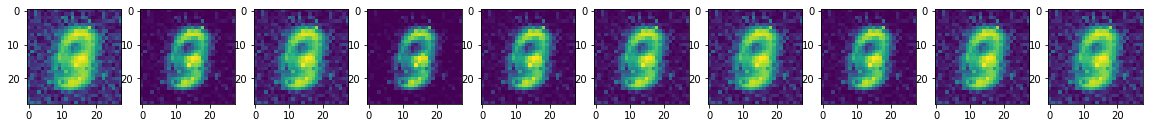

mean epoch 0 val loss: 594.1838656152997

Saving validation results for epoch 0
validation prediction: val//val_epoch_0_pred
validation label: val//val_epoch_0_labels



mean epoch 1 train loss: 567.2109513341777



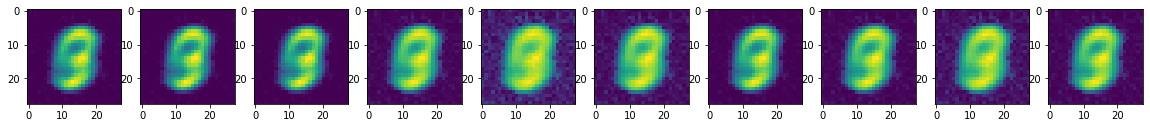

mean epoch 1 val loss: 549.0612403324673

Saving validation results for epoch 1
validation prediction: val//val_epoch_1_pred
validation label: val//val_epoch_1_labels



mean epoch 2 train loss: 548.8058808093934



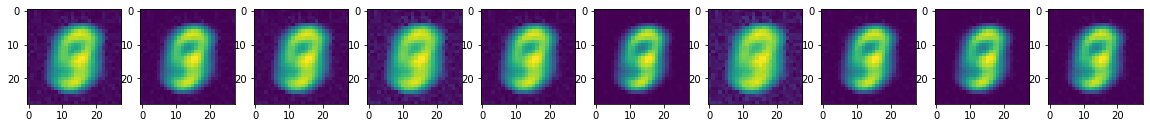

mean epoch 2 val loss: 538.0104772022793

Saving validation results for epoch 2
validation prediction: val//val_epoch_2_pred
validation label: val//val_epoch_2_labels



mean epoch 3 train loss: 537.6211805998005



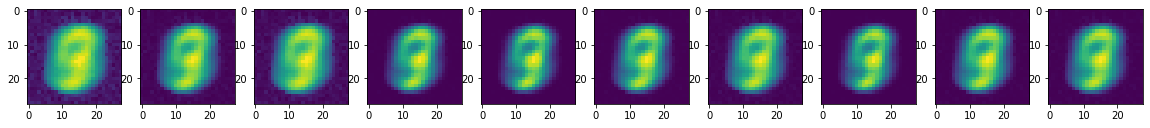

mean epoch 3 val loss: 528.1921216419765

Saving validation results for epoch 3
validation prediction: val//val_epoch_3_pred
validation label: val//val_epoch_3_labels



mean epoch 4 train loss: 529.0504417462344



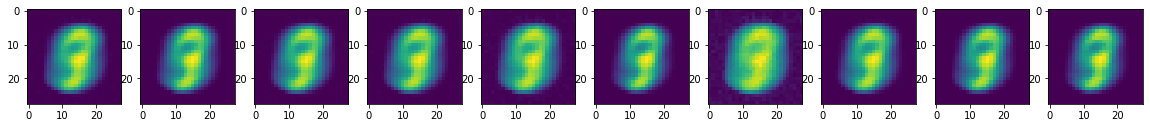

mean epoch 4 val loss: 521.0704036440168

Saving validation results for epoch 4
validation prediction: val//val_epoch_4_pred
validation label: val//val_epoch_4_labels



mean epoch 5 train loss: 522.3370267269448



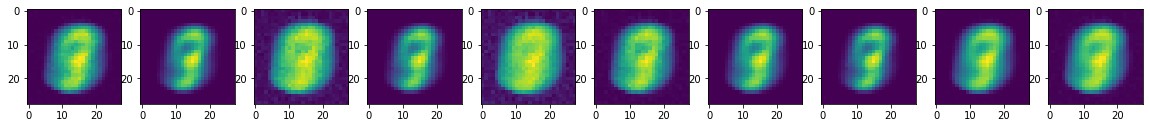

mean epoch 5 val loss: 515.009788785662

Saving validation results for epoch 5
validation prediction: val//val_epoch_5_pred
validation label: val//val_epoch_5_labels



mean epoch 6 train loss: 515.634224650294



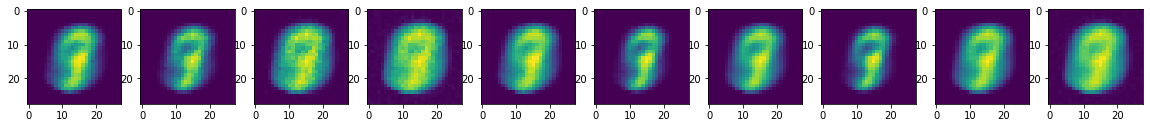

mean epoch 6 val loss: 507.93365403584073

Saving validation results for epoch 6
validation prediction: val//val_epoch_6_pred
validation label: val//val_epoch_6_labels



mean epoch 7 train loss: 506.41893752004756



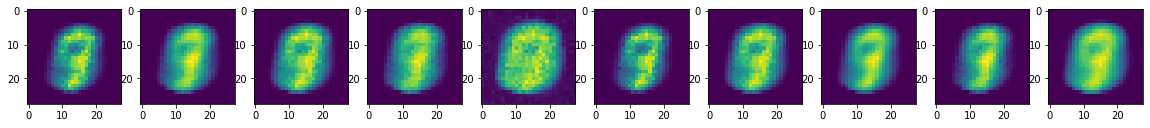

mean epoch 7 val loss: 497.36540154048373

Saving validation results for epoch 7
validation prediction: val//val_epoch_7_pred
validation label: val//val_epoch_7_labels



mean epoch 8 train loss: 493.7828219813893



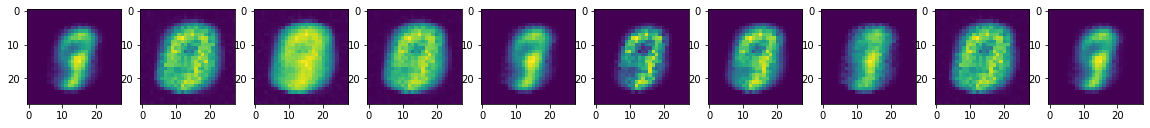

mean epoch 8 val loss: 484.96568005425587

Saving validation results for epoch 8
validation prediction: val//val_epoch_8_pred
validation label: val//val_epoch_8_labels



mean epoch 9 train loss: 481.0207174878287



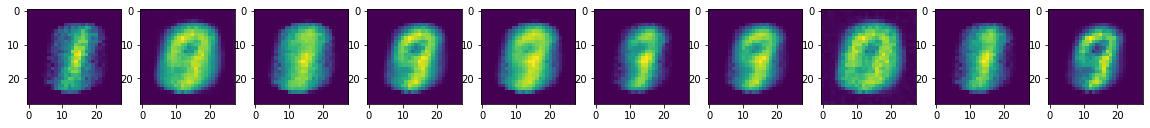

mean epoch 9 val loss: 474.16167984689986

Saving validation results for epoch 9
validation prediction: val//val_epoch_9_pred
validation label: val//val_epoch_9_labels



mean epoch 10 train loss: 471.11522421391663



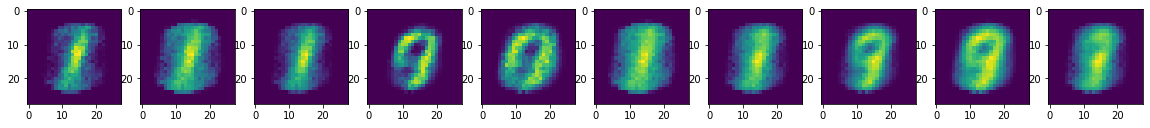

mean epoch 10 val loss: 466.256731578282

Saving validation results for epoch 10
validation prediction: val//val_epoch_10_pred
validation label: val//val_epoch_10_labels



mean epoch 11 train loss: 464.02336719628795



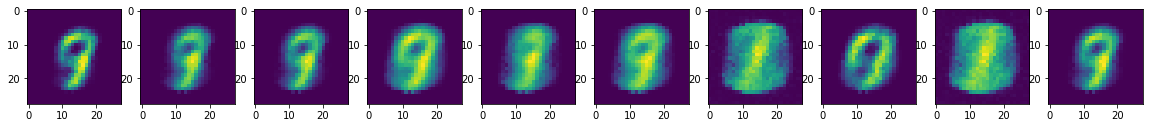

mean epoch 11 val loss: 460.5066407067435

Saving validation results for epoch 11
validation prediction: val//val_epoch_11_pred
validation label: val//val_epoch_11_labels



mean epoch 12 train loss: 458.61392325196414



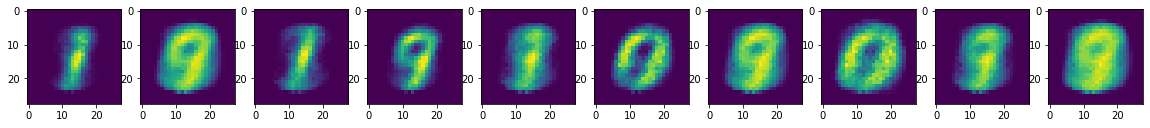

mean epoch 12 val loss: 455.6506495475769

Saving validation results for epoch 12
validation prediction: val//val_epoch_12_pred
validation label: val//val_epoch_12_labels



mean epoch 13 train loss: 453.71353757019386



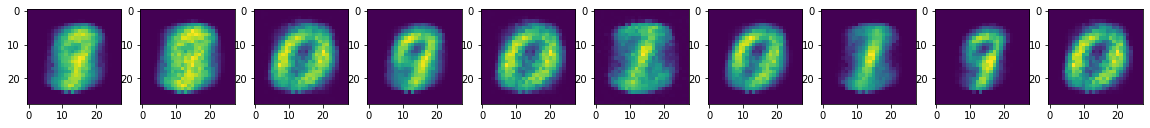

mean epoch 13 val loss: 450.48967940466747

Saving validation results for epoch 13
validation prediction: val//val_epoch_13_pred
validation label: val//val_epoch_13_labels



mean epoch 14 train loss: 448.2088169230921



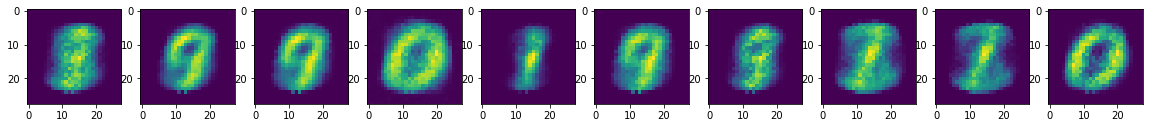

mean epoch 14 val loss: 444.2305338723319

Saving validation results for epoch 14
validation prediction: val//val_epoch_14_pred
validation label: val//val_epoch_14_labels



mean epoch 15 train loss: 442.1544049394949



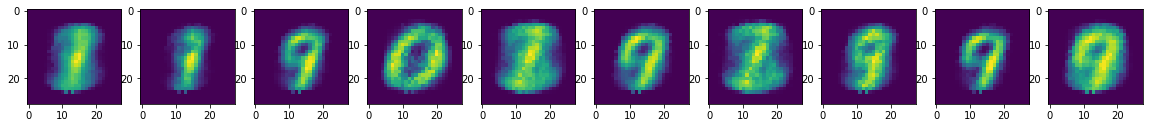

mean epoch 15 val loss: 438.17519501277377

Saving validation results for epoch 15
validation prediction: val//val_epoch_15_pred
validation label: val//val_epoch_15_labels



mean epoch 16 train loss: 435.7920079783728



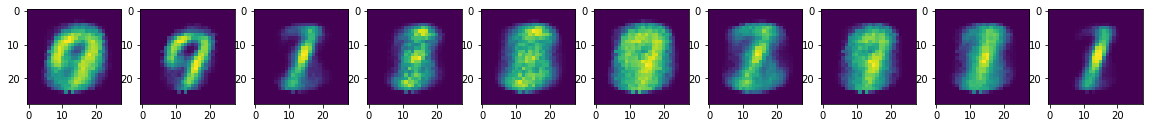

mean epoch 16 val loss: 431.04051208496094

Saving validation results for epoch 16
validation prediction: val//val_epoch_16_pred
validation label: val//val_epoch_16_labels



mean epoch 17 train loss: 429.1162324954742



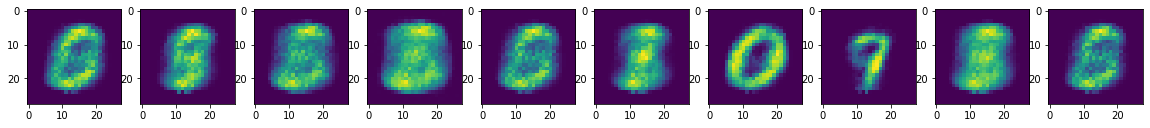

mean epoch 17 val loss: 424.4576768193926

Saving validation results for epoch 17
validation prediction: val//val_epoch_17_pred
validation label: val//val_epoch_17_labels



mean epoch 18 train loss: 423.0771869534985



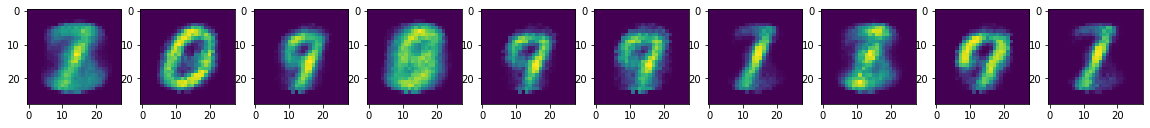

mean epoch 18 val loss: 418.85833501815796

Saving validation results for epoch 18
validation prediction: val//val_epoch_18_pred
validation label: val//val_epoch_18_labels



mean epoch 19 train loss: 417.71146192861755



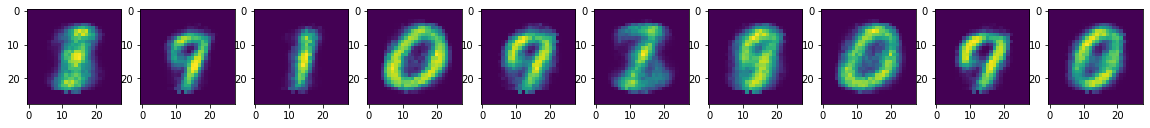

mean epoch 19 val loss: 413.6952380452837

Saving validation results for epoch 19
validation prediction: val//val_epoch_19_pred
validation label: val//val_epoch_19_labels



mean epoch 20 train loss: 413.0120759670056



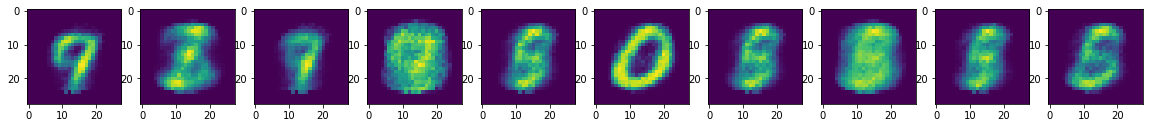

mean epoch 20 val loss: 408.940696648189

Saving validation results for epoch 20
validation prediction: val//val_epoch_20_pred
validation label: val//val_epoch_20_labels



mean epoch 21 train loss: 408.580786414302



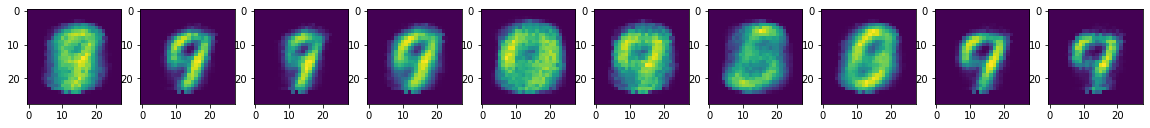

mean epoch 21 val loss: 404.75965472630094

Saving validation results for epoch 21
validation prediction: val//val_epoch_21_pred
validation label: val//val_epoch_21_labels



mean epoch 22 train loss: 404.0592371250835



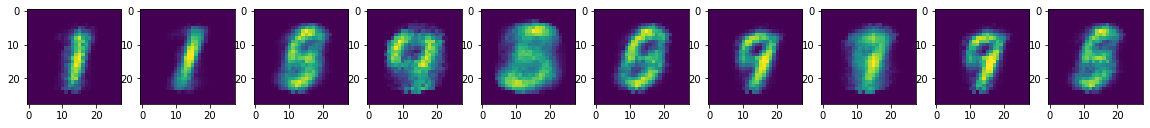

mean epoch 22 val loss: 399.82482733045305

Saving validation results for epoch 22
validation prediction: val//val_epoch_22_pred
validation label: val//val_epoch_22_labels



mean epoch 23 train loss: 399.0132541892499



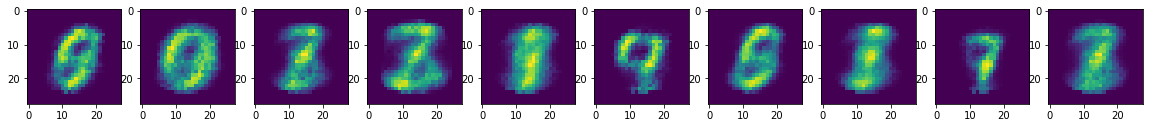

mean epoch 23 val loss: 394.3432364463806

Saving validation results for epoch 23
validation prediction: val//val_epoch_23_pred
validation label: val//val_epoch_23_labels



mean epoch 24 train loss: 393.65071650055586



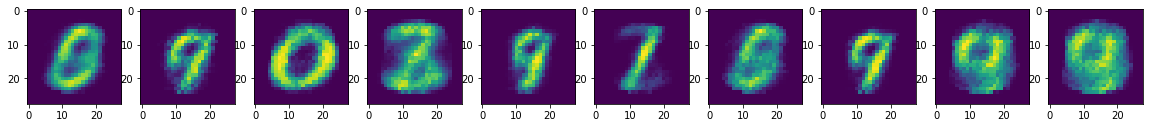

mean epoch 24 val loss: 388.6383093425206

Saving validation results for epoch 24
validation prediction: val//val_epoch_24_pred
validation label: val//val_epoch_24_labels



mean epoch 25 train loss: 388.03850288519845



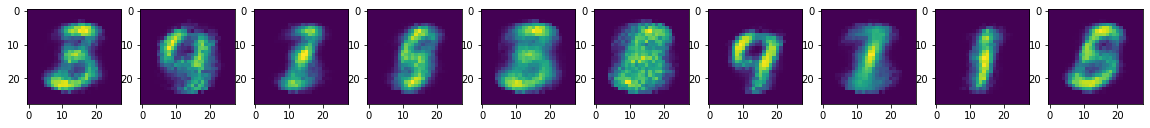

mean epoch 25 val loss: 382.6653894015721

Saving validation results for epoch 25
validation prediction: val//val_epoch_25_pred
validation label: val//val_epoch_25_labels



mean epoch 26 train loss: 382.35517246516673



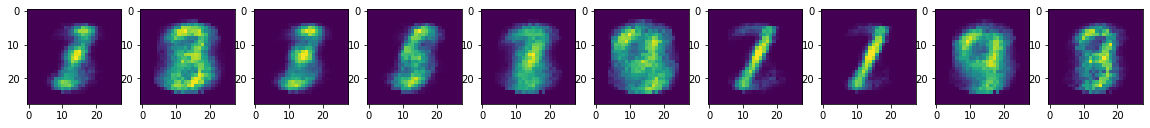

mean epoch 26 val loss: 376.51465586253573

Saving validation results for epoch 26
validation prediction: val//val_epoch_26_pred
validation label: val//val_epoch_26_labels



mean epoch 27 train loss: 376.7103993401887



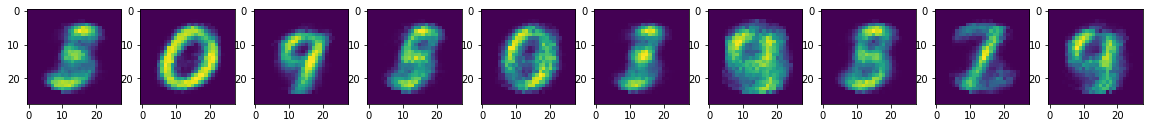

mean epoch 27 val loss: 370.8295569079263

Saving validation results for epoch 27
validation prediction: val//val_epoch_27_pred
validation label: val//val_epoch_27_labels



mean epoch 28 train loss: 371.2300873660934



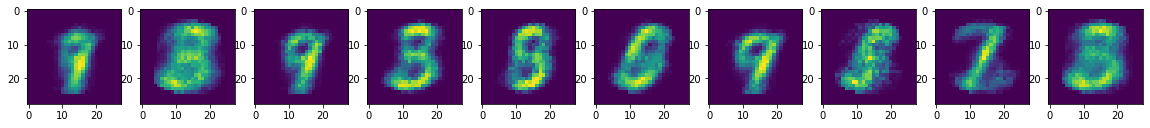

mean epoch 28 val loss: 365.1844461985997

Saving validation results for epoch 28
validation prediction: val//val_epoch_28_pred
validation label: val//val_epoch_28_labels



mean epoch 29 train loss: 366.0591372306489



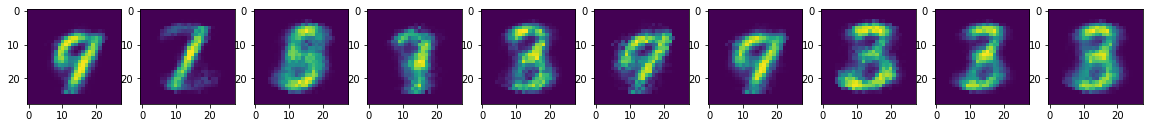

mean epoch 29 val loss: 360.0736539704459

Saving validation results for epoch 29
validation prediction: val//val_epoch_29_pred
validation label: val//val_epoch_29_labels



mean epoch 30 train loss: 361.1432898814284



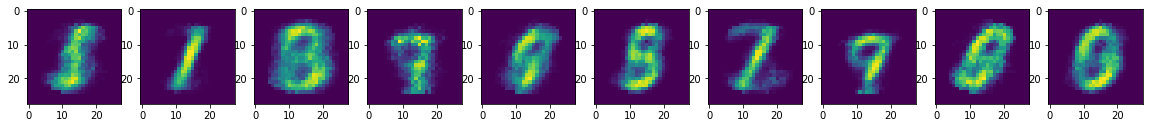

mean epoch 30 val loss: 354.9144711153848

Saving validation results for epoch 30
validation prediction: val//val_epoch_30_pred
validation label: val//val_epoch_30_labels



mean epoch 31 train loss: 356.5420137626382



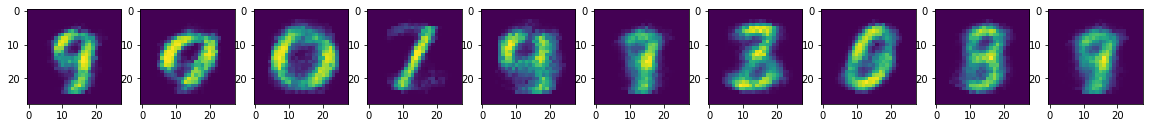

mean epoch 31 val loss: 350.52163110460555

Saving validation results for epoch 31
validation prediction: val//val_epoch_31_pred
validation label: val//val_epoch_31_labels



mean epoch 32 train loss: 352.25438955369225



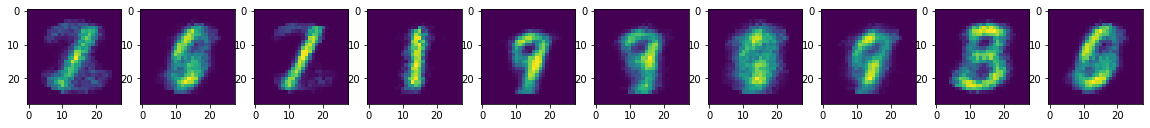

mean epoch 32 val loss: 346.31772232055664

Saving validation results for epoch 32
validation prediction: val//val_epoch_32_pred
validation label: val//val_epoch_32_labels



mean epoch 33 train loss: 348.242356822783



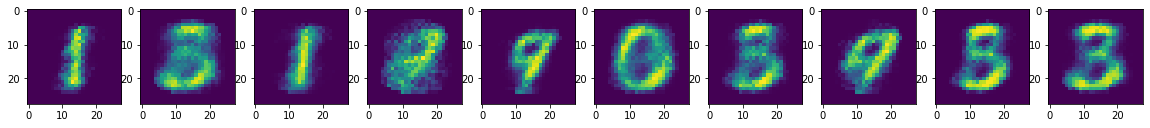

mean epoch 33 val loss: 342.48892525264193

Saving validation results for epoch 33
validation prediction: val//val_epoch_33_pred
validation label: val//val_epoch_33_labels



mean epoch 34 train loss: 344.46104292124005



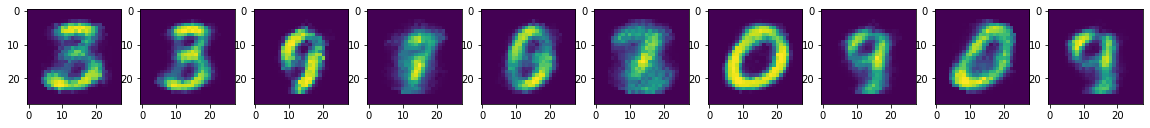

mean epoch 34 val loss: 338.76158714294434

Saving validation results for epoch 34
validation prediction: val//val_epoch_34_pred
validation label: val//val_epoch_34_labels



mean epoch 35 train loss: 340.9238878728568



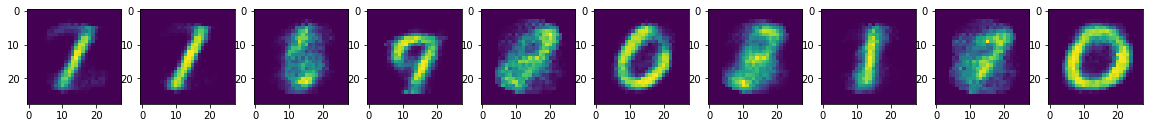

mean epoch 35 val loss: 335.12930502210344

Saving validation results for epoch 35
validation prediction: val//val_epoch_35_pred
validation label: val//val_epoch_35_labels



mean epoch 36 train loss: 337.66638966271796



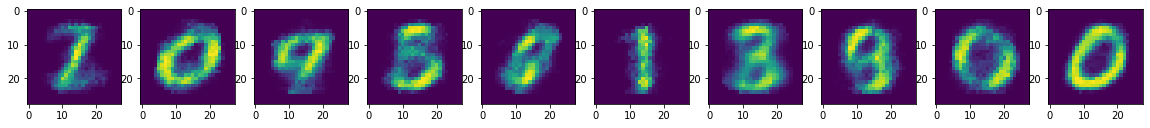

mean epoch 36 val loss: 332.03528574534823

Saving validation results for epoch 36
validation prediction: val//val_epoch_36_pred
validation label: val//val_epoch_36_labels



mean epoch 37 train loss: 334.5852228600209



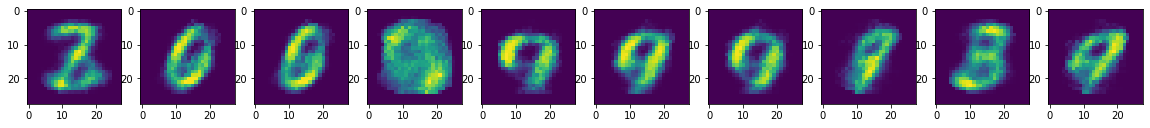

mean epoch 37 val loss: 329.0185949461801

Saving validation results for epoch 37
validation prediction: val//val_epoch_37_pred
validation label: val//val_epoch_37_labels



mean epoch 38 train loss: 331.55036474856536



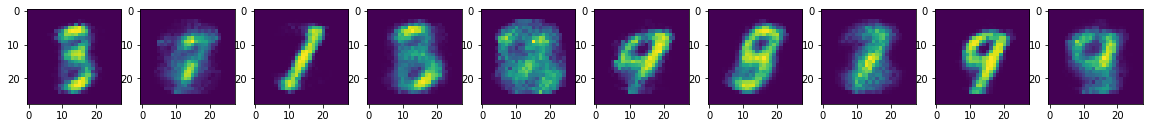

mean epoch 38 val loss: 326.138363293239

Saving validation results for epoch 38
validation prediction: val//val_epoch_38_pred
validation label: val//val_epoch_38_labels



mean epoch 39 train loss: 328.712734381179



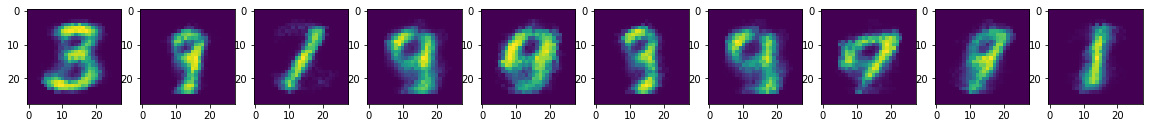

mean epoch 39 val loss: 323.5547753061567

Saving validation results for epoch 39
validation prediction: val//val_epoch_39_pred
validation label: val//val_epoch_39_labels



mean epoch 40 train loss: 325.959171325203



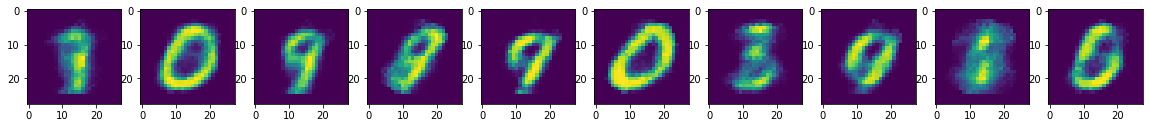

mean epoch 40 val loss: 320.817200251988

Saving validation results for epoch 40
validation prediction: val//val_epoch_40_pred
validation label: val//val_epoch_40_labels



mean epoch 41 train loss: 323.3197084819506



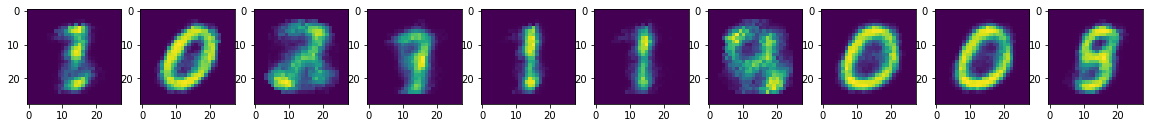

mean epoch 41 val loss: 318.16762396267484

Saving validation results for epoch 41
validation prediction: val//val_epoch_41_pred
validation label: val//val_epoch_41_labels



mean epoch 42 train loss: 320.66451329509107



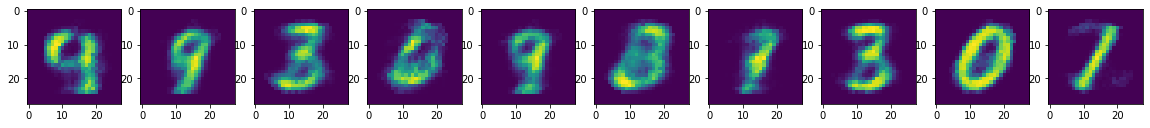

mean epoch 42 val loss: 315.840621812003

Saving validation results for epoch 42
validation prediction: val//val_epoch_42_pred
validation label: val//val_epoch_42_labels



mean epoch 43 train loss: 318.186105528618



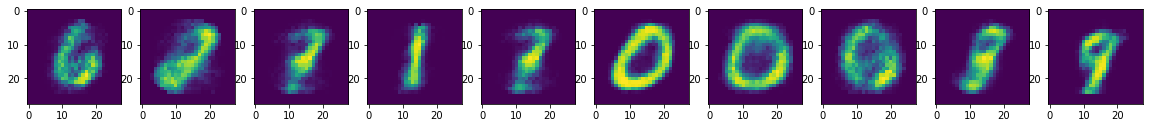

mean epoch 43 val loss: 313.48036657060896

Saving validation results for epoch 43
validation prediction: val//val_epoch_43_pred
validation label: val//val_epoch_43_labels



mean epoch 44 train loss: 315.73077505860476



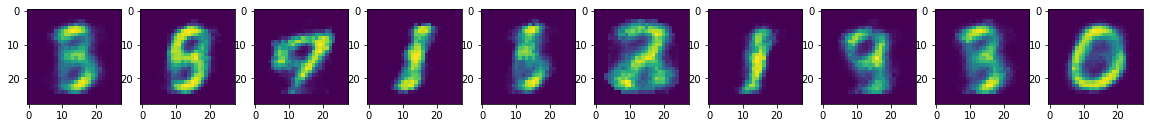

mean epoch 44 val loss: 311.0531021186284

Saving validation results for epoch 44
validation prediction: val//val_epoch_44_pred
validation label: val//val_epoch_44_labels



mean epoch 45 train loss: 313.38775123278657



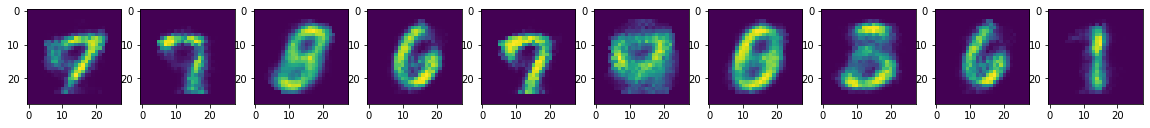

mean epoch 45 val loss: 308.5106747491019

Saving validation results for epoch 45
validation prediction: val//val_epoch_45_pred
validation label: val//val_epoch_45_labels



mean epoch 46 train loss: 311.0845021954806



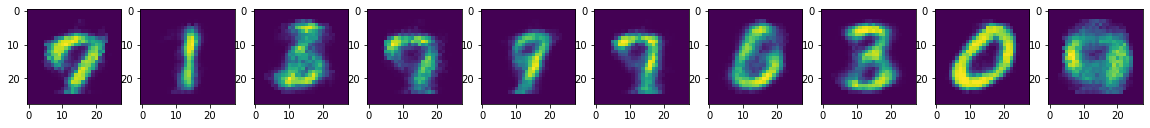

mean epoch 46 val loss: 306.20677968433927

Saving validation results for epoch 46
validation prediction: val//val_epoch_46_pred
validation label: val//val_epoch_46_labels



mean epoch 47 train loss: 308.9303986556887



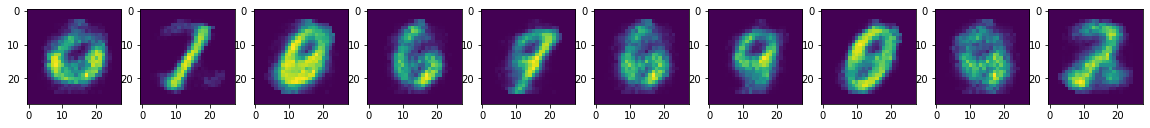

mean epoch 47 val loss: 304.0042939526694

Saving validation results for epoch 47
validation prediction: val//val_epoch_47_pred
validation label: val//val_epoch_47_labels



mean epoch 48 train loss: 306.83292722755664



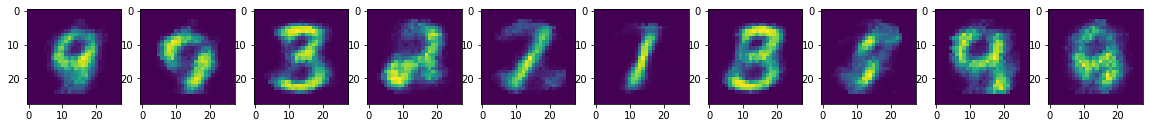

mean epoch 48 val loss: 302.07261364800587

Saving validation results for epoch 48
validation prediction: val//val_epoch_48_pred
validation label: val//val_epoch_48_labels



mean epoch 49 train loss: 304.8647760964084



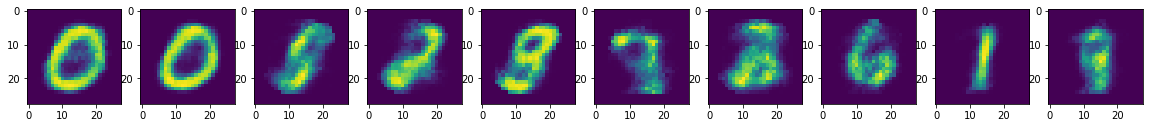

mean epoch 49 val loss: 300.12193284715926

Saving validation results for epoch 49
validation prediction: val//val_epoch_49_pred
validation label: val//val_epoch_49_labels



mean epoch 50 train loss: 302.9264449987422



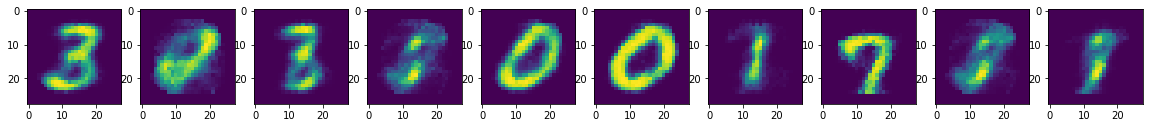

mean epoch 50 val loss: 297.79549244471957

Saving validation results for epoch 50
validation prediction: val//val_epoch_50_pred
validation label: val//val_epoch_50_labels



mean epoch 51 train loss: 301.049351609598



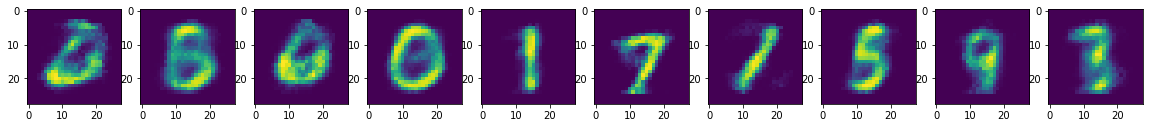

mean epoch 51 val loss: 296.0941960471017

Saving validation results for epoch 51
validation prediction: val//val_epoch_51_pred
validation label: val//val_epoch_51_labels



mean epoch 52 train loss: 299.18147228056455



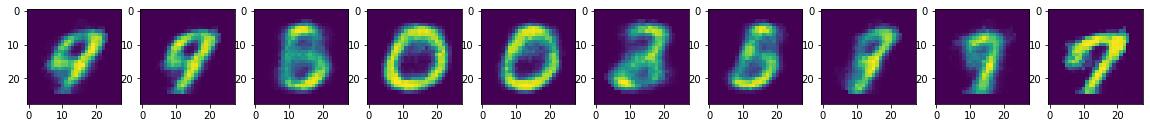

mean epoch 52 val loss: 294.3622010775975

Saving validation results for epoch 52
validation prediction: val//val_epoch_52_pred
validation label: val//val_epoch_52_labels



mean epoch 53 train loss: 297.4755318537606



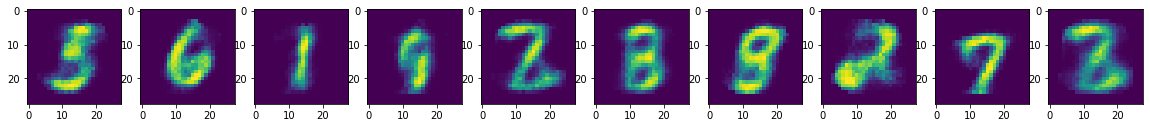

mean epoch 53 val loss: 292.33787543433056

Saving validation results for epoch 53
validation prediction: val//val_epoch_53_pred
validation label: val//val_epoch_53_labels



mean epoch 54 train loss: 295.7615597084483



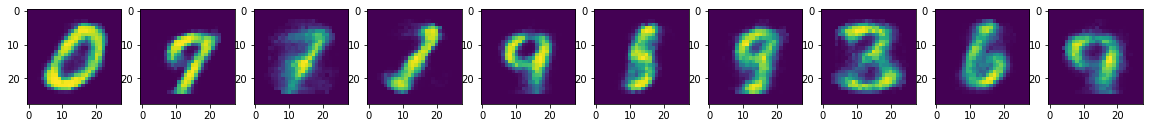

mean epoch 54 val loss: 290.6711456775665

Saving validation results for epoch 54
validation prediction: val//val_epoch_54_pred
validation label: val//val_epoch_54_labels



mean epoch 55 train loss: 294.0830047229814



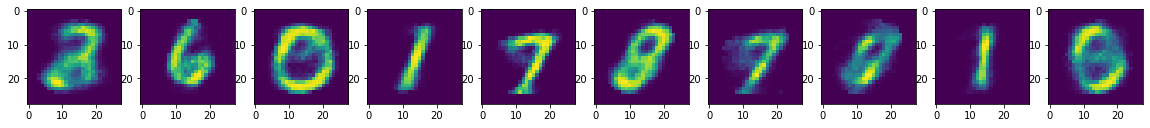

mean epoch 55 val loss: 289.19144913128446

Saving validation results for epoch 55
validation prediction: val//val_epoch_55_pred
validation label: val//val_epoch_55_labels



mean epoch 56 train loss: 292.4426250307579



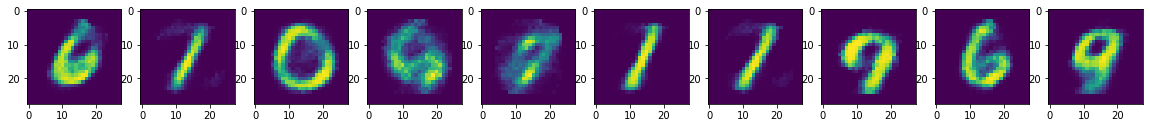

mean epoch 56 val loss: 287.18651138033186

Saving validation results for epoch 56
validation prediction: val//val_epoch_56_pred
validation label: val//val_epoch_56_labels



mean epoch 57 train loss: 290.87822544024954



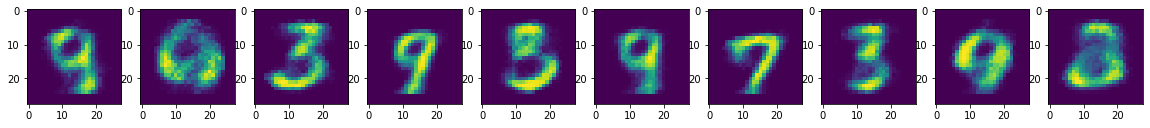

mean epoch 57 val loss: 286.12963587897167

Saving validation results for epoch 57
validation prediction: val//val_epoch_57_pred
validation label: val//val_epoch_57_labels



mean epoch 58 train loss: 289.3079481607615



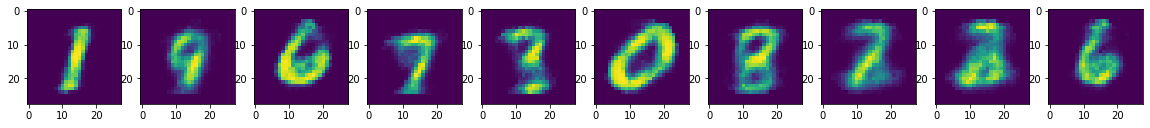

mean epoch 58 val loss: 284.3833441053118

Saving validation results for epoch 58
validation prediction: val//val_epoch_58_pred
validation label: val//val_epoch_58_labels



mean epoch 59 train loss: 287.72607056281964



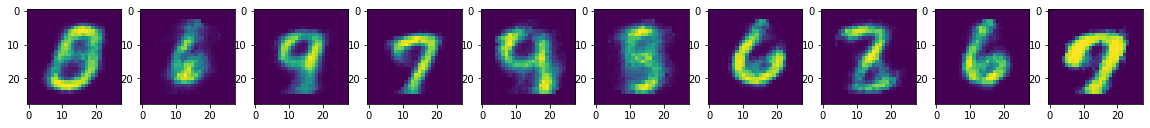

mean epoch 59 val loss: 282.7862490245274

Saving validation results for epoch 59
validation prediction: val//val_epoch_59_pred
validation label: val//val_epoch_59_labels



mean epoch 60 train loss: 286.22187204436057



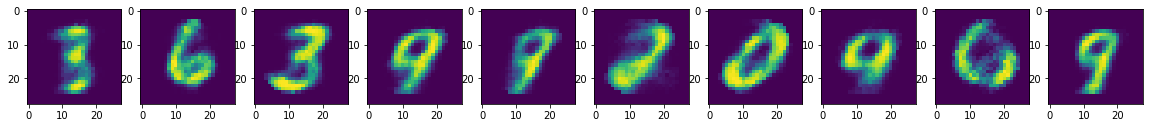

mean epoch 60 val loss: 281.06403752735685

Saving validation results for epoch 60
validation prediction: val//val_epoch_60_pred
validation label: val//val_epoch_60_labels



mean epoch 61 train loss: 284.6666583650158



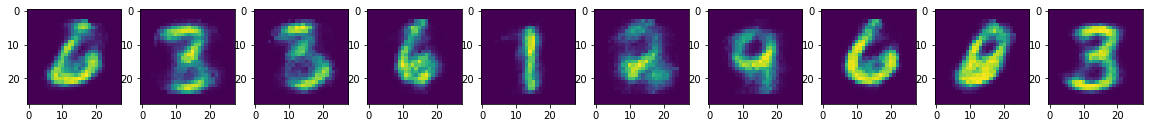

mean epoch 61 val loss: 279.87215307780673

Saving validation results for epoch 61
validation prediction: val//val_epoch_61_pred
validation label: val//val_epoch_61_labels



mean epoch 62 train loss: 283.1466435710276



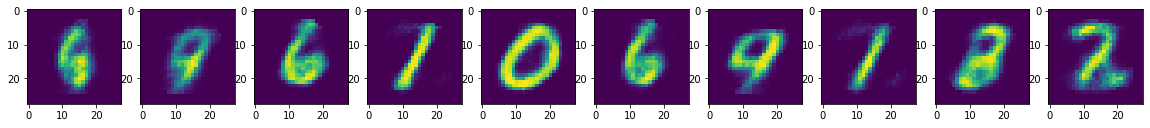

mean epoch 62 val loss: 278.42624551909313

Saving validation results for epoch 62
validation prediction: val//val_epoch_62_pred
validation label: val//val_epoch_62_labels



mean epoch 63 train loss: 281.6743062108386



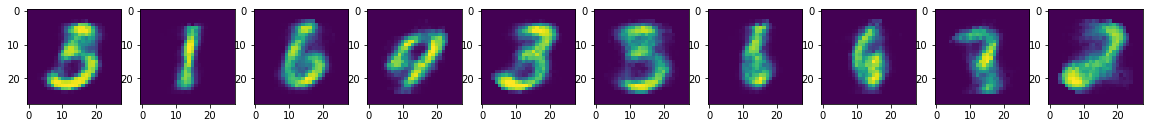

mean epoch 63 val loss: 276.41631514685497

Saving validation results for epoch 63
validation prediction: val//val_epoch_63_pred
validation label: val//val_epoch_63_labels



mean epoch 64 train loss: 280.14891266795996



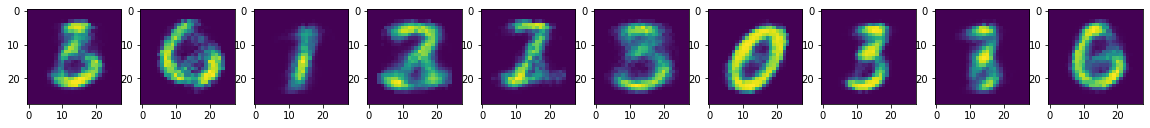

mean epoch 64 val loss: 275.21843024662564

Saving validation results for epoch 64
validation prediction: val//val_epoch_64_pred
validation label: val//val_epoch_64_labels



mean epoch 65 train loss: 278.6849457233373



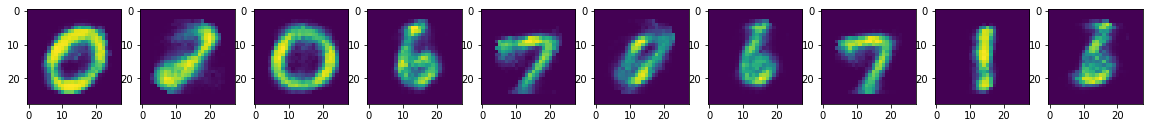

mean epoch 65 val loss: 273.505886895316

Saving validation results for epoch 65
validation prediction: val//val_epoch_65_pred
validation label: val//val_epoch_65_labels



mean epoch 66 train loss: 277.2550440853707



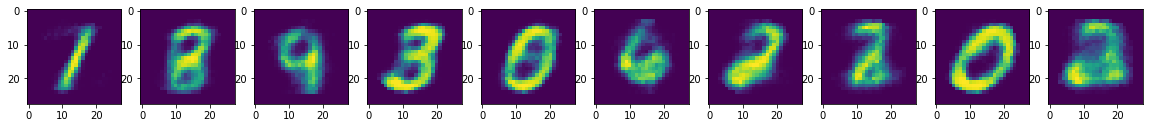

mean epoch 66 val loss: 272.04929539135526

Saving validation results for epoch 66
validation prediction: val//val_epoch_66_pred
validation label: val//val_epoch_66_labels



mean epoch 67 train loss: 275.9206442559396



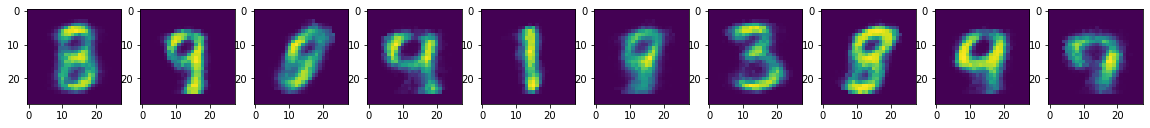

mean epoch 67 val loss: 270.64633311544145

Saving validation results for epoch 67
validation prediction: val//val_epoch_67_pred
validation label: val//val_epoch_67_labels



mean epoch 68 train loss: 274.48024707704076



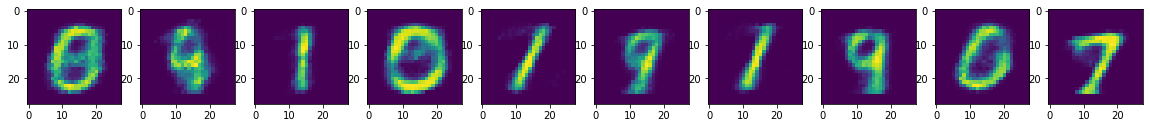

mean epoch 68 val loss: 269.7311521257673

Saving validation results for epoch 68
validation prediction: val//val_epoch_68_pred
validation label: val//val_epoch_68_labels



mean epoch 69 train loss: 273.19856694739633



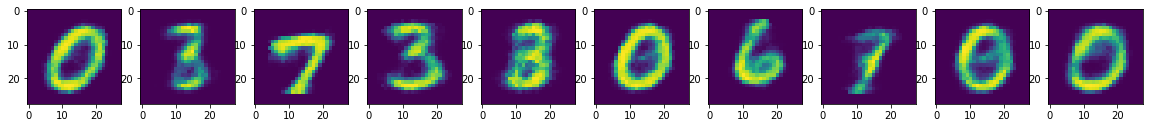

mean epoch 69 val loss: 268.3233407224928

Saving validation results for epoch 69
validation prediction: val//val_epoch_69_pred
validation label: val//val_epoch_69_labels



mean epoch 70 train loss: 271.9109072261506



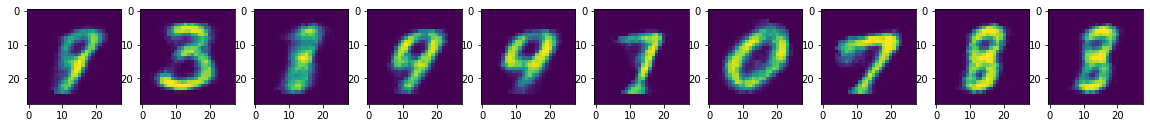

mean epoch 70 val loss: 267.08921691349576

Saving validation results for epoch 70
validation prediction: val//val_epoch_70_pred
validation label: val//val_epoch_70_labels



mean epoch 71 train loss: 270.6446821386554



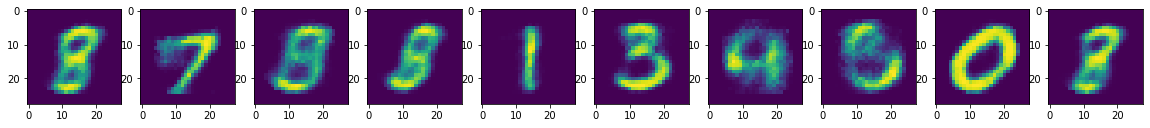

mean epoch 71 val loss: 265.89955248151506

Saving validation results for epoch 71
validation prediction: val//val_epoch_71_pred
validation label: val//val_epoch_71_labels



mean epoch 72 train loss: 269.43621579010386



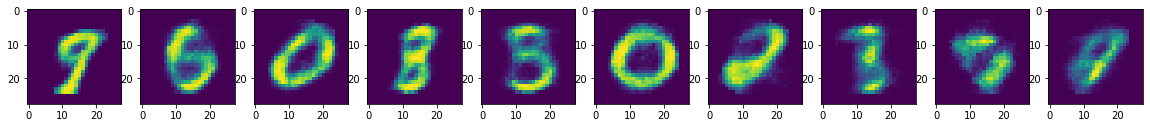

mean epoch 72 val loss: 264.9079805782863

Saving validation results for epoch 72
validation prediction: val//val_epoch_72_pred
validation label: val//val_epoch_72_labels



mean epoch 73 train loss: 268.30972312352253



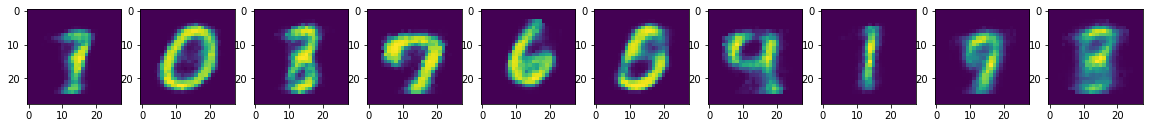

mean epoch 73 val loss: 263.73884662560056

Saving validation results for epoch 73
validation prediction: val//val_epoch_73_pred
validation label: val//val_epoch_73_labels



mean epoch 74 train loss: 267.179155210274



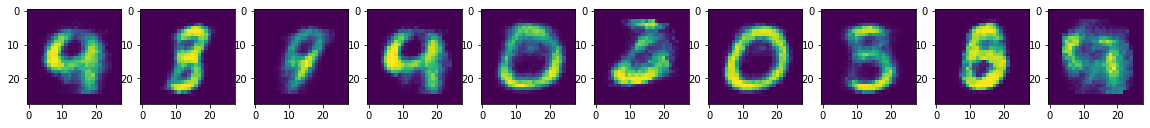

mean epoch 74 val loss: 262.5070423398699

Saving validation results for epoch 74
validation prediction: val//val_epoch_74_pred
validation label: val//val_epoch_74_labels



mean epoch 75 train loss: 266.07561282661015



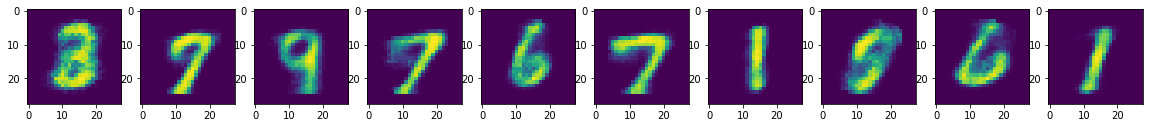

mean epoch 75 val loss: 261.51618099212646

Saving validation results for epoch 75
validation prediction: val//val_epoch_75_pred
validation label: val//val_epoch_75_labels



mean epoch 76 train loss: 265.0356781726747



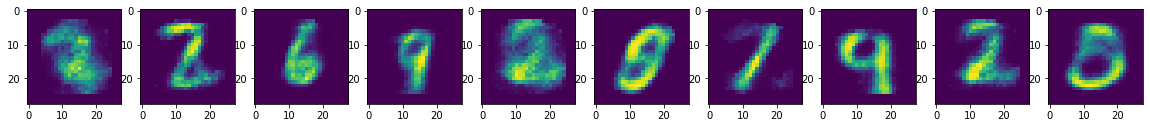

mean epoch 76 val loss: 260.79684775216236

Saving validation results for epoch 76
validation prediction: val//val_epoch_76_pred
validation label: val//val_epoch_76_labels



mean epoch 77 train loss: 263.99027855511594



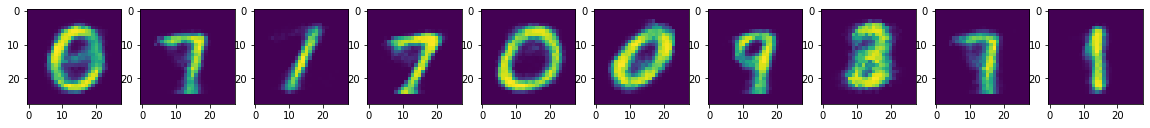

mean epoch 77 val loss: 259.7156536579132

Saving validation results for epoch 77
validation prediction: val//val_epoch_77_pred
validation label: val//val_epoch_77_labels



mean epoch 78 train loss: 263.0848912001997



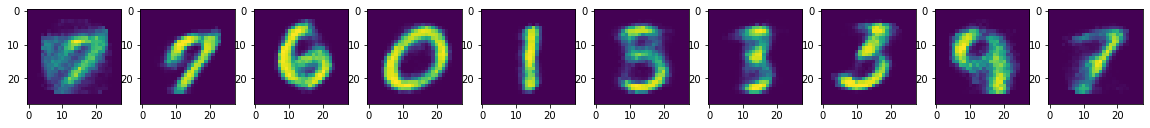

mean epoch 78 val loss: 258.9010346617018

Saving validation results for epoch 78
validation prediction: val//val_epoch_78_pred
validation label: val//val_epoch_78_labels



mean epoch 79 train loss: 262.12044100337675



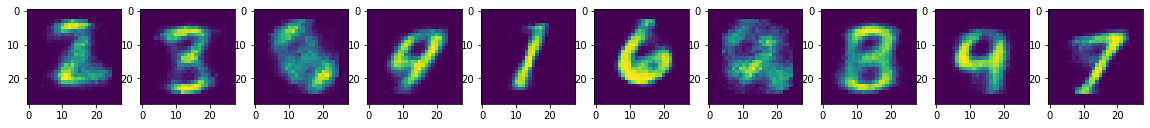

mean epoch 79 val loss: 257.9032452787672

Saving validation results for epoch 79
validation prediction: val//val_epoch_79_pred
validation label: val//val_epoch_79_labels



mean epoch 80 train loss: 261.1783564838972



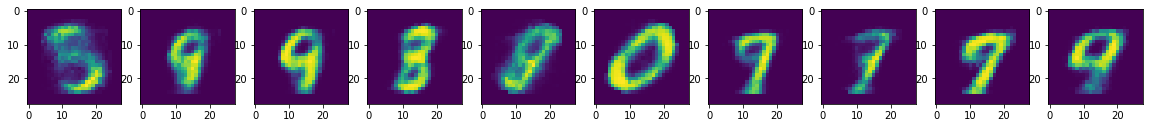

mean epoch 80 val loss: 257.18841777529036

Saving validation results for epoch 80
validation prediction: val//val_epoch_80_pred
validation label: val//val_epoch_80_labels



mean epoch 81 train loss: 260.3466001323962



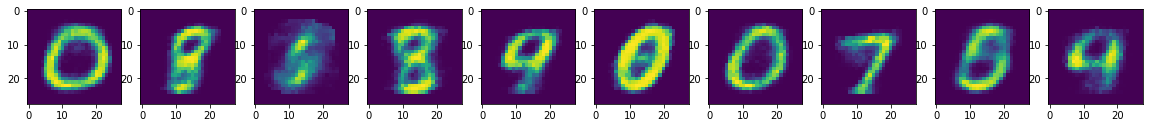

mean epoch 81 val loss: 256.5605531420027

Saving validation results for epoch 81
validation prediction: val//val_epoch_81_pred
validation label: val//val_epoch_81_labels



mean epoch 82 train loss: 259.44461359940175



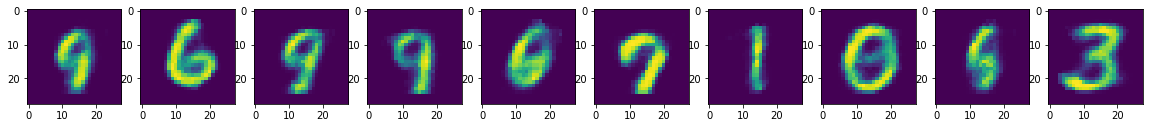

mean epoch 82 val loss: 255.4686339242118

Saving validation results for epoch 82
validation prediction: val//val_epoch_82_pred
validation label: val//val_epoch_82_labels



mean epoch 83 train loss: 258.6315966542848



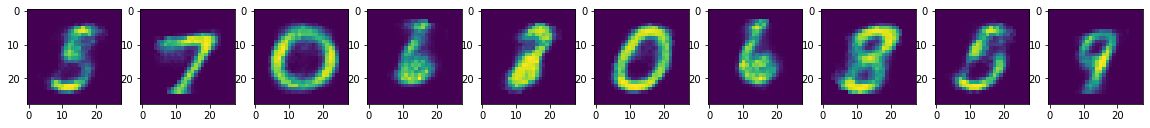

mean epoch 83 val loss: 254.6929657459259

Saving validation results for epoch 83
validation prediction: val//val_epoch_83_pred
validation label: val//val_epoch_83_labels



mean epoch 84 train loss: 257.7776497496529



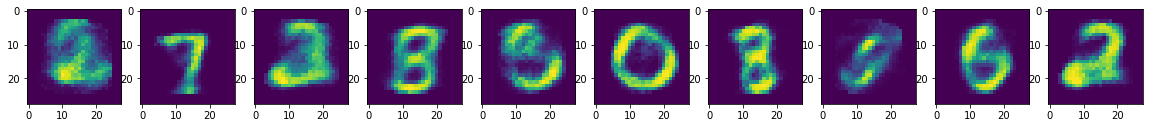

mean epoch 84 val loss: 253.92812262262618

Saving validation results for epoch 84
validation prediction: val//val_epoch_84_pred
validation label: val//val_epoch_84_labels



mean epoch 85 train loss: 256.97741084747827



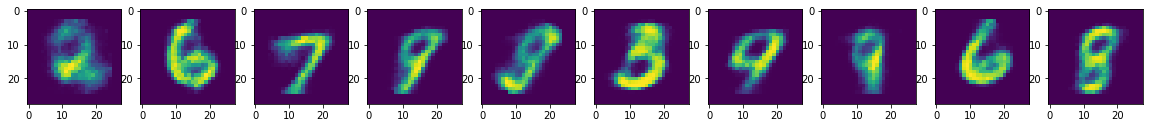

mean epoch 85 val loss: 253.0453646183014

Saving validation results for epoch 85
validation prediction: val//val_epoch_85_pred
validation label: val//val_epoch_85_labels



mean epoch 86 train loss: 256.23371821983864



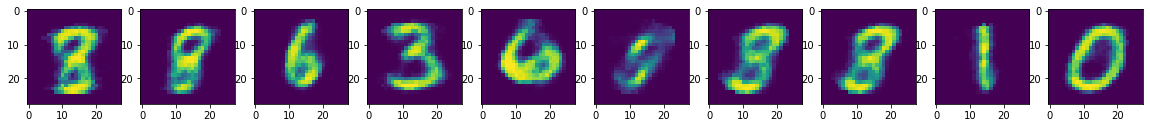

mean epoch 86 val loss: 252.79978982039862

Saving validation results for epoch 86
validation prediction: val//val_epoch_86_pred
validation label: val//val_epoch_86_labels



mean epoch 87 train loss: 255.4498779502843



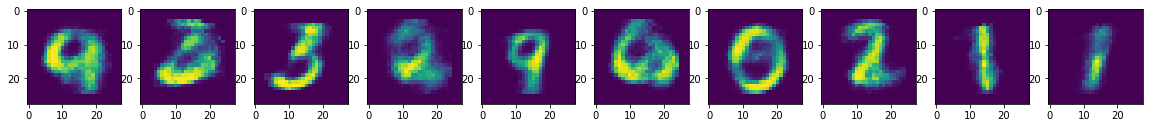

mean epoch 87 val loss: 251.72470261369432

Saving validation results for epoch 87
validation prediction: val//val_epoch_87_pred
validation label: val//val_epoch_87_labels



mean epoch 88 train loss: 254.72756839576266



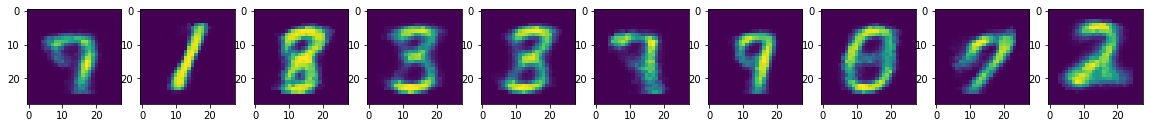

mean epoch 88 val loss: 251.0536571911403

Saving validation results for epoch 88
validation prediction: val//val_epoch_88_pred
validation label: val//val_epoch_88_labels



mean epoch 89 train loss: 254.0478269321712



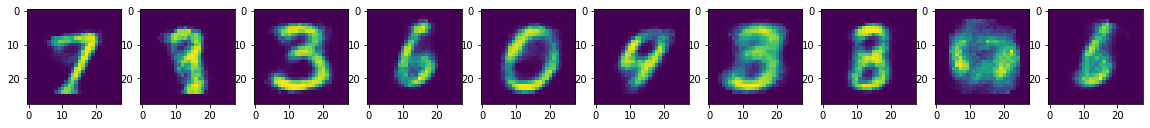

mean epoch 89 val loss: 250.51745591844832

Saving validation results for epoch 89
validation prediction: val//val_epoch_89_pred
validation label: val//val_epoch_89_labels



mean epoch 90 train loss: 253.32102964592195



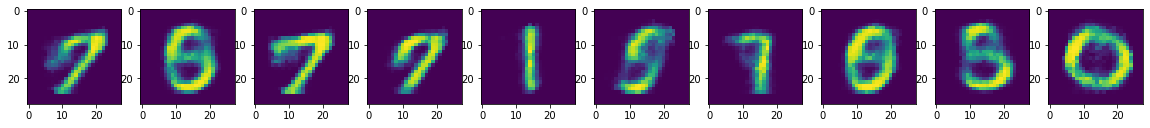

mean epoch 90 val loss: 250.00275060108729

Saving validation results for epoch 90
validation prediction: val//val_epoch_90_pred
validation label: val//val_epoch_90_labels



mean epoch 91 train loss: 252.63177114342946



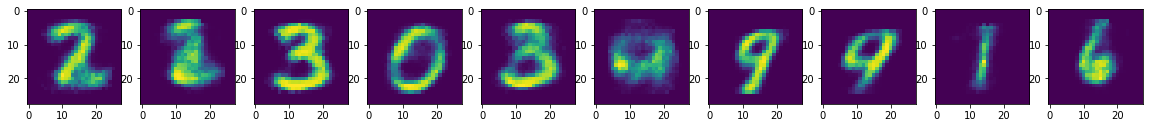

mean epoch 91 val loss: 249.27728543962752

Saving validation results for epoch 91
validation prediction: val//val_epoch_91_pred
validation label: val//val_epoch_91_labels



mean epoch 92 train loss: 251.9804614896313



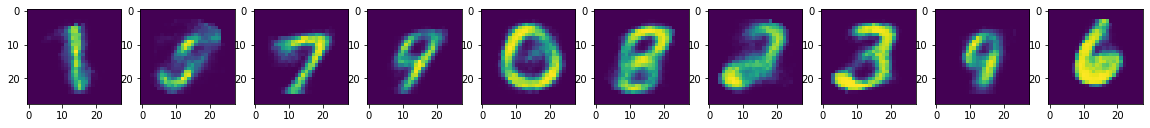

mean epoch 92 val loss: 248.53822582108634

Saving validation results for epoch 92
validation prediction: val//val_epoch_92_pred
validation label: val//val_epoch_92_labels



mean epoch 93 train loss: 251.31327941688562



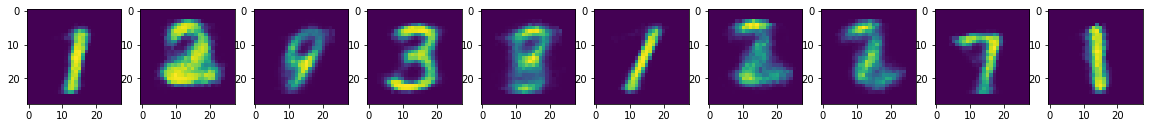

mean epoch 93 val loss: 248.20204632622855

Saving validation results for epoch 93
validation prediction: val//val_epoch_93_pred
validation label: val//val_epoch_93_labels



mean epoch 94 train loss: 250.70726203703907



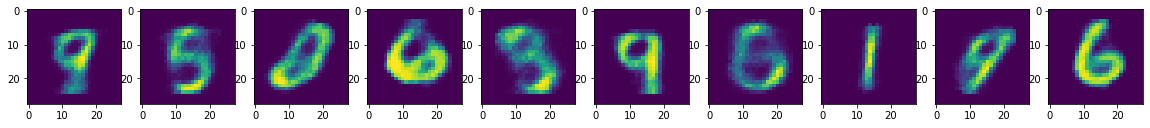

mean epoch 94 val loss: 247.56749146325248

Saving validation results for epoch 94
validation prediction: val//val_epoch_94_pred
validation label: val//val_epoch_94_labels



mean epoch 95 train loss: 250.04633093577536



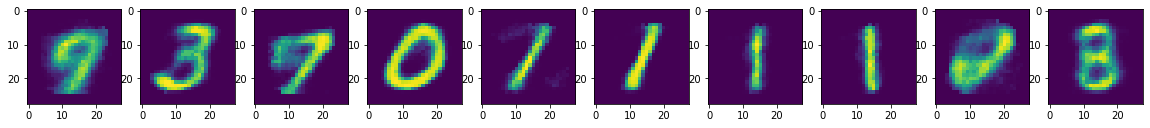

mean epoch 95 val loss: 247.1869876044137

Saving validation results for epoch 95
validation prediction: val//val_epoch_95_pred
validation label: val//val_epoch_95_labels



mean epoch 96 train loss: 249.40723742730705



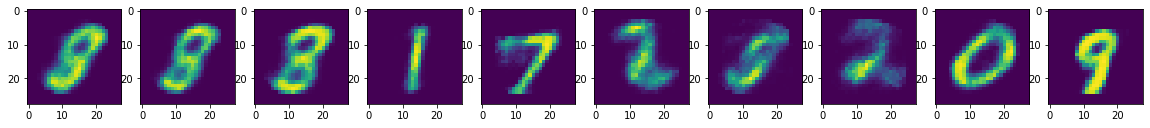

mean epoch 96 val loss: 246.40203983443124

Saving validation results for epoch 96
validation prediction: val//val_epoch_96_pred
validation label: val//val_epoch_96_labels



mean epoch 97 train loss: 248.87140905253665



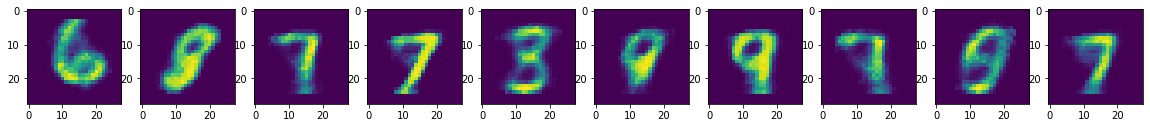

mean epoch 97 val loss: 245.8437727178846

Saving validation results for epoch 97
validation prediction: val//val_epoch_97_pred
validation label: val//val_epoch_97_labels



mean epoch 98 train loss: 248.2631229018736



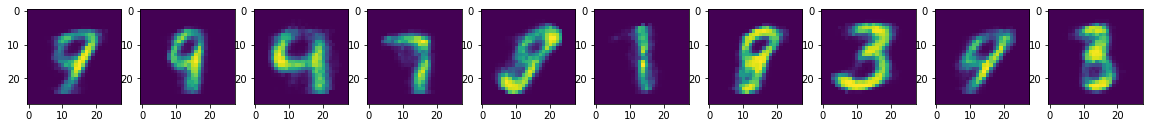

mean epoch 98 val loss: 245.04482405526298

Saving validation results for epoch 98
validation prediction: val//val_epoch_98_pred
validation label: val//val_epoch_98_labels



mean epoch 99 train loss: 247.66221929320602



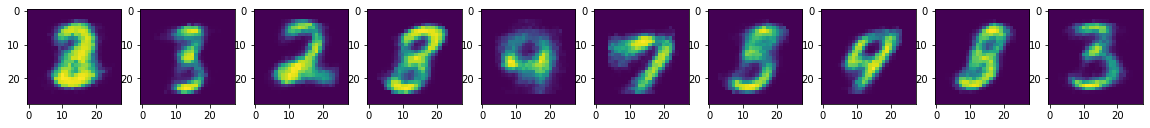

mean epoch 99 val loss: 244.6728526524135

Saving validation results for epoch 99
validation prediction: val//val_epoch_99_pred
validation label: val//val_epoch_99_labels



In [17]:
val_dir = "val/"
try:
    os.makedirs(val_dir)
except FileExistsError:
    pass
train_state_dir = "net_states/"
try:
    os.makedirs(train_state_dir)
except FileExistsError:
    pass

epoch = 0
val_i = 0
train_start_time = time.time()
for epoch in tqdm(range(epochs)):
    
    batch_nr = 0
    epoch_loss = np.zeros(len(train_loader))
    
    """Actual training step"""
    for train_mini_batch in tqdm(train_loader):
        
        batch_loss, train_output = utils.step(net, train_mini_batch[0], train_mini_batch[0], loss_func, optimizer, device, mode="train", log_file=log_file)
        epoch_loss[batch_nr] = batch_loss.item()
        batch_nr += 1
    
    mean_epoch_loss = epoch_loss.mean()
    train_loss[epoch] = mean_epoch_loss
    print(f"mean epoch {epoch} train loss: {mean_epoch_loss}\n")
    
    
    """save the neural networks state"""
    if epoch in save_state_epochs:
        train_state_epoch_file_path = train_state_dir + f"state_epoch_{epoch}"
        #train_state = {"epoch" : epoch, "state_dict": net.state_dict(), "optimizer": optimizer.state_dict()}
        #torch.save(train_state, train_state_epoch_file_path)
        torch.save(net.state_dict(), train_state_epoch_file_path)
        net_state_paths.append(train_state_epoch_file_path)
        print(f"saved model from epoch {epoch}")
        
    """
    Validation
    """
    #val_epochs = [100000]
    if epoch in val_epochs:
        val_label = []
        val_pred = []
        
        val_batch_nr = 0
        val_epoch_loss = np.zeros(len(val_loader))
        
        for val_mini_batch in val_loader:
            label_batch = val_mini_batch[1]
            val_label.append(label_batch.detach().cpu().numpy())
            val_batch_loss, val_output = utils.step(net, val_mini_batch[0], val_mini_batch[0], loss_func, optimizer, device, mode="val", log_file=log_file)
            val_epoch_loss[val_batch_nr] = val_batch_loss.item()
            val_pred.append(val_output.detach().cpu().numpy())
            
            if val_batch_nr == 0:
                num_images = 10
                fig, ax = plt.subplots(1,num_images)
                for i in range(num_images):
                    ax[i].imshow(val_pred[-1].reshape((batch_size,1,28,28))[i,0])
                plt.show()
                #ax[1].imshow(val_label[0].reshape((batch_size,1,28,28))[0,0])
            
            val_batch_nr += 1
            
        mean_val_epoch_loss = val_epoch_loss.mean()
        val_loss[val_i] = mean_val_epoch_loss
        print(f"mean epoch {epoch} val loss: {mean_val_epoch_loss}\n")
        
        val_i += 1
        
        print(f"Saving validation results for epoch {epoch}")
        
        val_pred_path = val_dir + "/" + f"val_epoch_{epoch}_pred"
        val_label_path = val_dir + "/" + f"val_epoch_{epoch}_labels"
        #print(np.array(functools.reduce(operator.iconcat, val_pred, [])))
        np.array(functools.reduce(operator.iconcat, val_pred, [])).tofile(val_pred_path, sep=" ")
        np.array(functools.reduce(operator.iconcat, val_label, [])).tofile(val_label_path, sep=" ")
        #np.array(val_pred).tofile(val_pred_path)
        #np.array(val_label).tofile(val_pred_label)
        
        val_pred_paths.append(val_pred_path)
        val_label_paths.append(val_label_path)
        print(f"validation prediction: {val_pred_path}")
        print(f"validation label: {val_label_path}")
        
log_file.close()
train_end_time = time.time()

In [18]:
print(f"training time: {train_end_time-train_start_time}s")

training time: 1006.6417875289917s


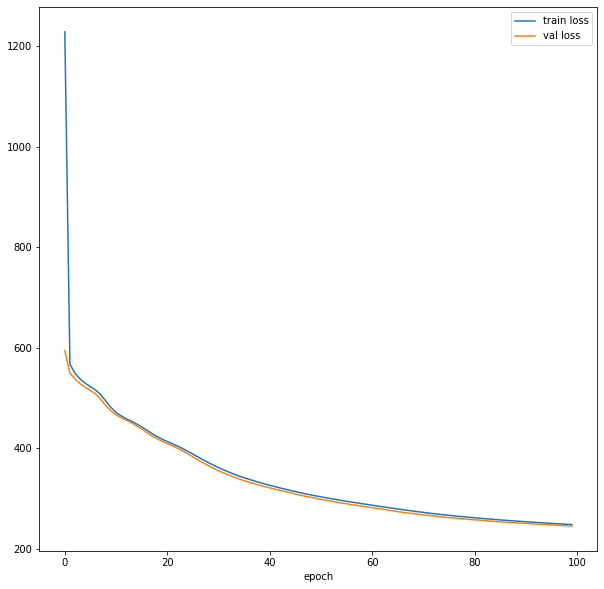

In [19]:
"""Plot training loss curve and save as image"""
plt.rcParams['figure.figsize'] = [10, 10]
loss_img_file_name = "train_loss.png"
x_epochs = range(epochs)
fig, ax = plt.subplots()
ax.plot(x_epochs, train_loss, label="train loss")
ax.plot(val_epochs, val_loss, label="val loss")
leg = ax.legend()
#plt.title()
plt.xlabel("epoch")
#plt.ylabel("loss")
plt.savefig(loss_img_file_name)
plt.show()
plt.close()
train_loss_txt_file_name = "train_loss.txt"
np.savetxt(train_loss_txt_file_name, train_loss)
val_loss_txt_file_name = "val_loss.txt"
np.savetxt(val_loss_txt_file_name, val_loss)

In [20]:
train_state_file_path = train_state_dir + f"state_epoch_{epoch}"
#train_state = {"epoch" : epoch, "state_dict": net.state_dict(), "optimizer": optimizer.state_dict()}
torch.save(net.state_dict(), train_state_file_path)
net_state_paths.append(train_state_file_path)
print(f"saved model from epoch {epoch}")

saved model from epoch 99


In [21]:
load_epoch = epoch
print(f"loading model from epoch {load_epoch}")
net_state_path = f"net_states/state_epoch_{load_epoch}"
net.load_state_dict(torch.load(net_state_path))
net.eval()

loading model from epoch 99


AutoEncoder(
  (encoder): Coder(
    (layers): ModuleList(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=196, bias=True)
      (2): Linear(in_features=196, out_features=98, bias=True)
      (3): Linear(in_features=98, out_features=49, bias=True)
      (4): Linear(in_features=49, out_features=10, bias=True)
    )
  )
  (decoder): Coder(
    (layers): ModuleList(
      (0): Linear(in_features=10, out_features=49, bias=True)
      (1): Linear(in_features=49, out_features=98, bias=True)
      (2): Linear(in_features=98, out_features=196, bias=True)
      (3): Linear(in_features=196, out_features=784, bias=True)
      (4): Reshape()
    )
  )
)

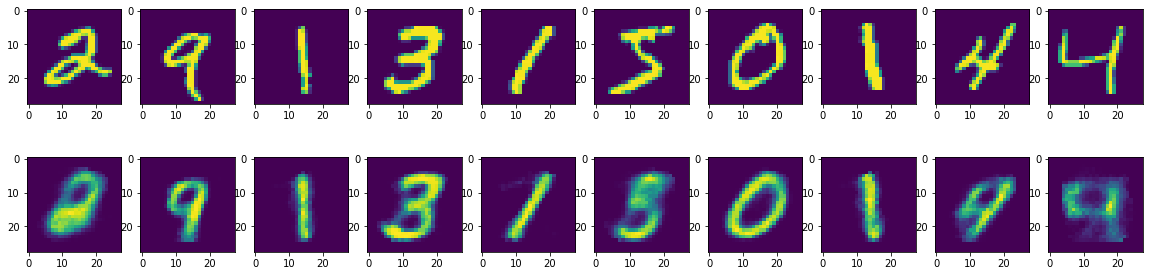

In [22]:
plt.rcParams['figure.figsize'] = [20, 5]
test_image, test_label = dataset[0]
indices = np.arange(0,10)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=test_sampler)
test_images = []
outputs = []
for test_batch in train_loader:
    test_image = test_batch[0].to(device)
    test_images.append(test_image)
    #plt.imshow(test_image.cpu()[0,0])
    net.eval()
    output = net.forward(test_image.float())
    outputs.append(output)

num_images = len(outputs)
fig, ax = plt.subplots(2,num_images)
for image_i in range(num_images):
    ax[0, image_i].imshow(test_images[image_i].cpu()[0,0])
    ax[1, image_i].imshow(outputs[image_i].detach().cpu()[0,0])

torch.Size([10, 1, 28, 28])
10


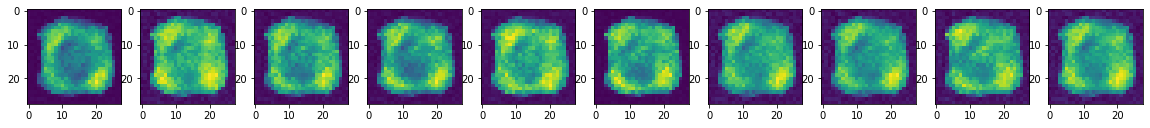

In [23]:
plt.rcParams['figure.figsize'] = [20, 5]
num_samples = 10
#latent_samples = torch.randint(low=1, high=1000, size=(num_samples, latent_size) )
latent_samples = torch.randn(size=(num_samples, latent_size) )

output = net.decoder(latent_samples.to(device).float())
print(output.size())
print(len(output))
fig, ax = plt.subplots(1,num_samples)
for i in range(num_samples):
    ax[i].imshow(output.detach().cpu()[i][0])
    

In [24]:
labels = np.array(dataset.label_df["number"], dtype=int)
sorted_label_indices = []
for class_num in range(0,10):
    sorted_label_indices.append(np.array(np.where(labels == class_num))[0])
    print(np.array(np.where(labels == class_num)).shape)
    
#print(len(sorted_label_indices))
#print(sorted_label_indices[0].size)
#print(sorted_label_indices[0][0])

(1, 1001)
(1, 1127)
(1, 991)
(1, 1032)
(1, 980)
(1, 863)
(1, 1014)
(1, 1070)
(1, 944)
(1, 978)


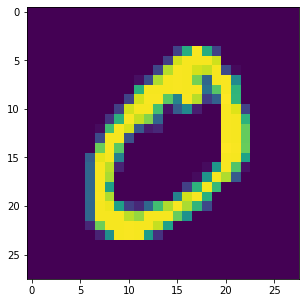

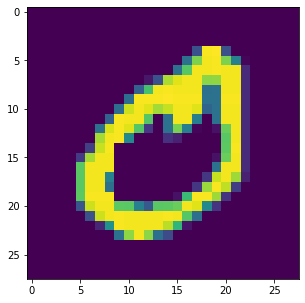

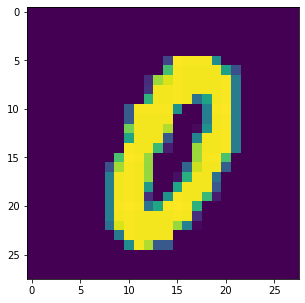

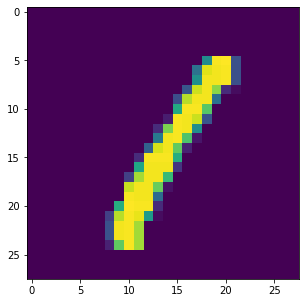

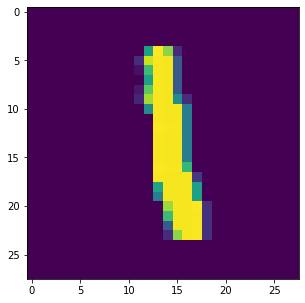

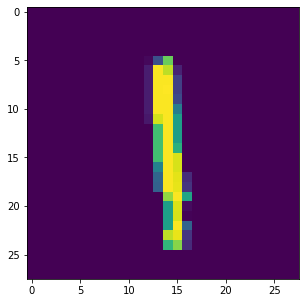

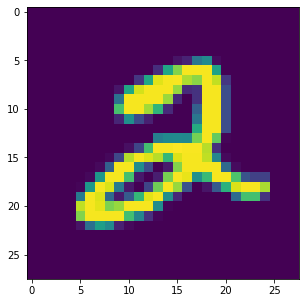

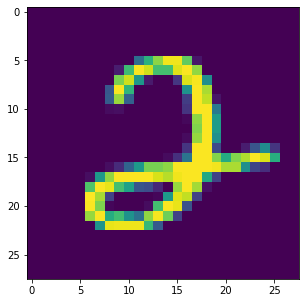

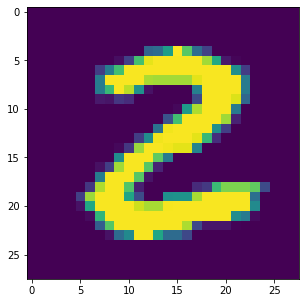

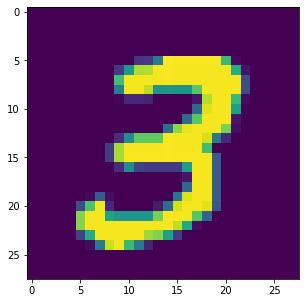

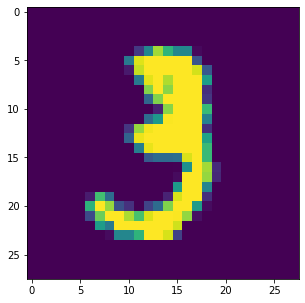

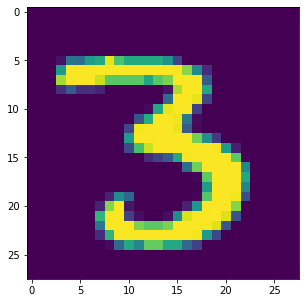

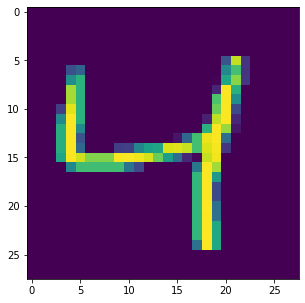

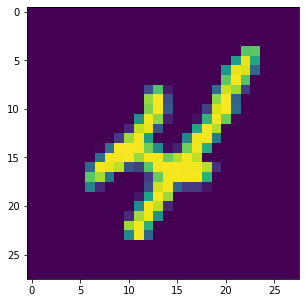

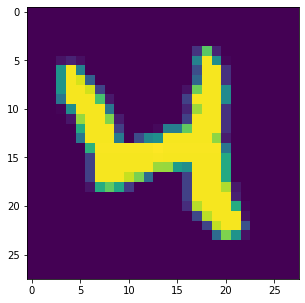

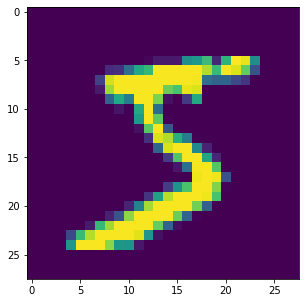

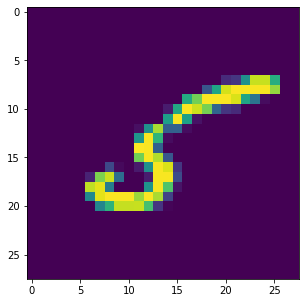

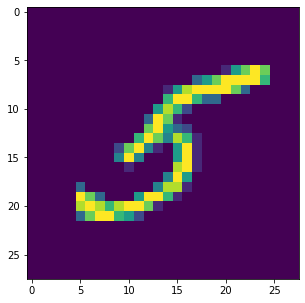

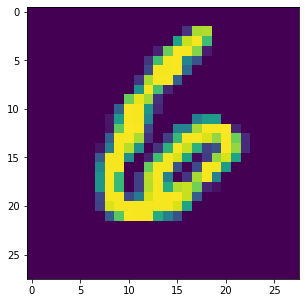

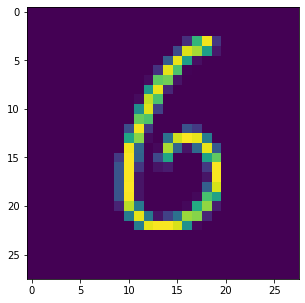

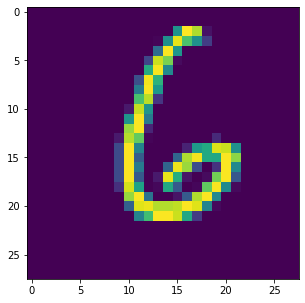

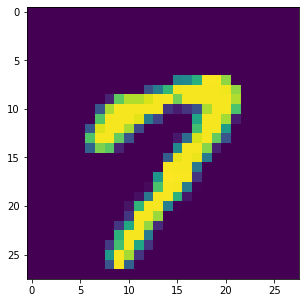

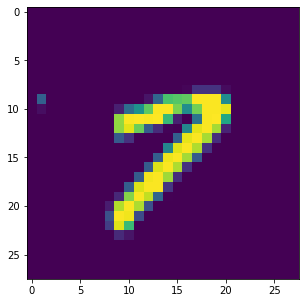

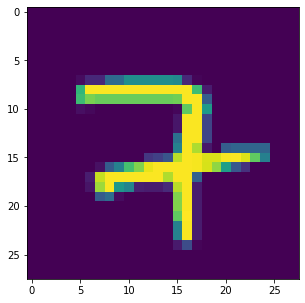

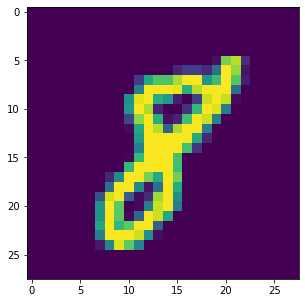

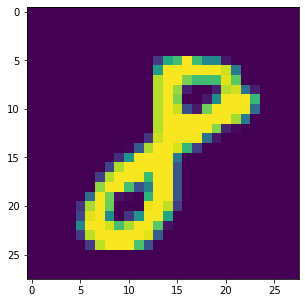

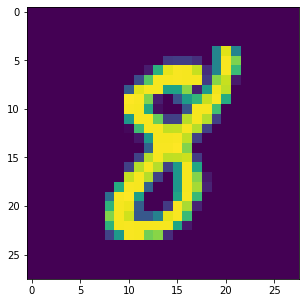

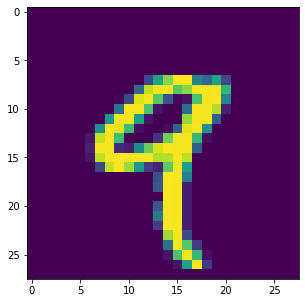

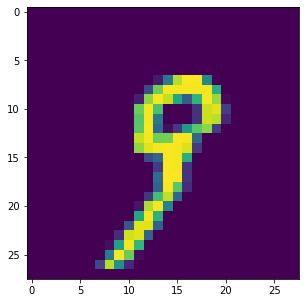

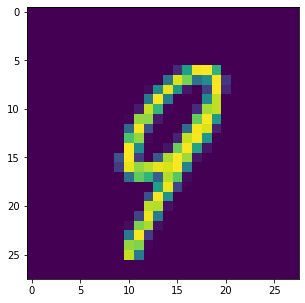

In [25]:
latent_vectors = []

for class_num in range(0,10):
    num_per_class = 100
    #num_per_class = len(sorted_label_indices[class_num]
    
    class_latent_vectors = np.zeros( (num_per_class,latent_size) )

    
    #for image_i in range(len(sorted_label_indices[class_num])):
    for image_i in tqdm(range(num_per_class)):
        #print(image_i)
        #get one image
        image_index = sorted_label_indices[class_num][image_i]
        #print(image_index)
        image = dataset.get_image(image_index)[0]
        if image_i < 3:
            plt.imshow(image.detach().cpu()[0])
            plt.show()
        
        #print(image.shape)
        
        #compress to latent space
        class_latent_vectors[image_i] = net.encoder(image.float()).detach().cpu()
        
    
    latent_vectors.append(class_latent_vectors)
    

In [26]:
latent_vectors = np.array(latent_vectors)
print(latent_vectors.shape)

(10, 100, 10)


In [27]:
mean_latent_vectors = latent_vectors.mean(axis=1)
std_latent_vectors = latent_vectors.std(axis=1)

print("mean latent vectors")
for i in range(0,10):
    print(f"number {i}")
    print(mean_latent_vectors[i])
    print("std")
    print(std_latent_vectors[i])


mean latent vectors
number 0
[0.00000000e+00 4.67543099e+01 2.04109255e+01 5.92770452e+00
 9.17793676e-02 2.45479528e+01 2.95703698e+01 3.78596564e+01
 9.68598895e+01 8.36940142e+00]
std
[ 0.         21.19549169  8.96351819  3.43160052  0.25968763  8.70671065
 11.04758425 16.12930796 38.24509022  4.44193177]
number 1
[0.00000000e+00 1.04374947e+02 2.36020453e+01 6.01506752e-02
 0.00000000e+00 3.53721156e+01 5.21758994e+01 2.53608553e+01
 1.19693306e+02 2.01051416e+01]
std
[ 0.         29.72974868  6.40671597  0.33984541  0.         20.36541563
 21.77571169 17.15836433 47.05539468  5.29561506]
number 2
[0.00000000e+00 4.44436561e+01 1.85605951e+01 6.84071720e-01
 2.64577456e-03 1.73548935e+01 2.25149232e+01 2.87271000e+01
 6.51124137e+01 1.17223915e+01]
std
[0.00000000e+00 1.60702449e+01 9.03868684e+00 9.89502644e-01
 1.90083837e-02 7.94388185e+00 1.17594108e+01 1.03339812e+01
 2.32121966e+01 4.25328821e+00]
number 3
[ 0.         54.93856537 13.62342881  2.01132781  0.         17.968598

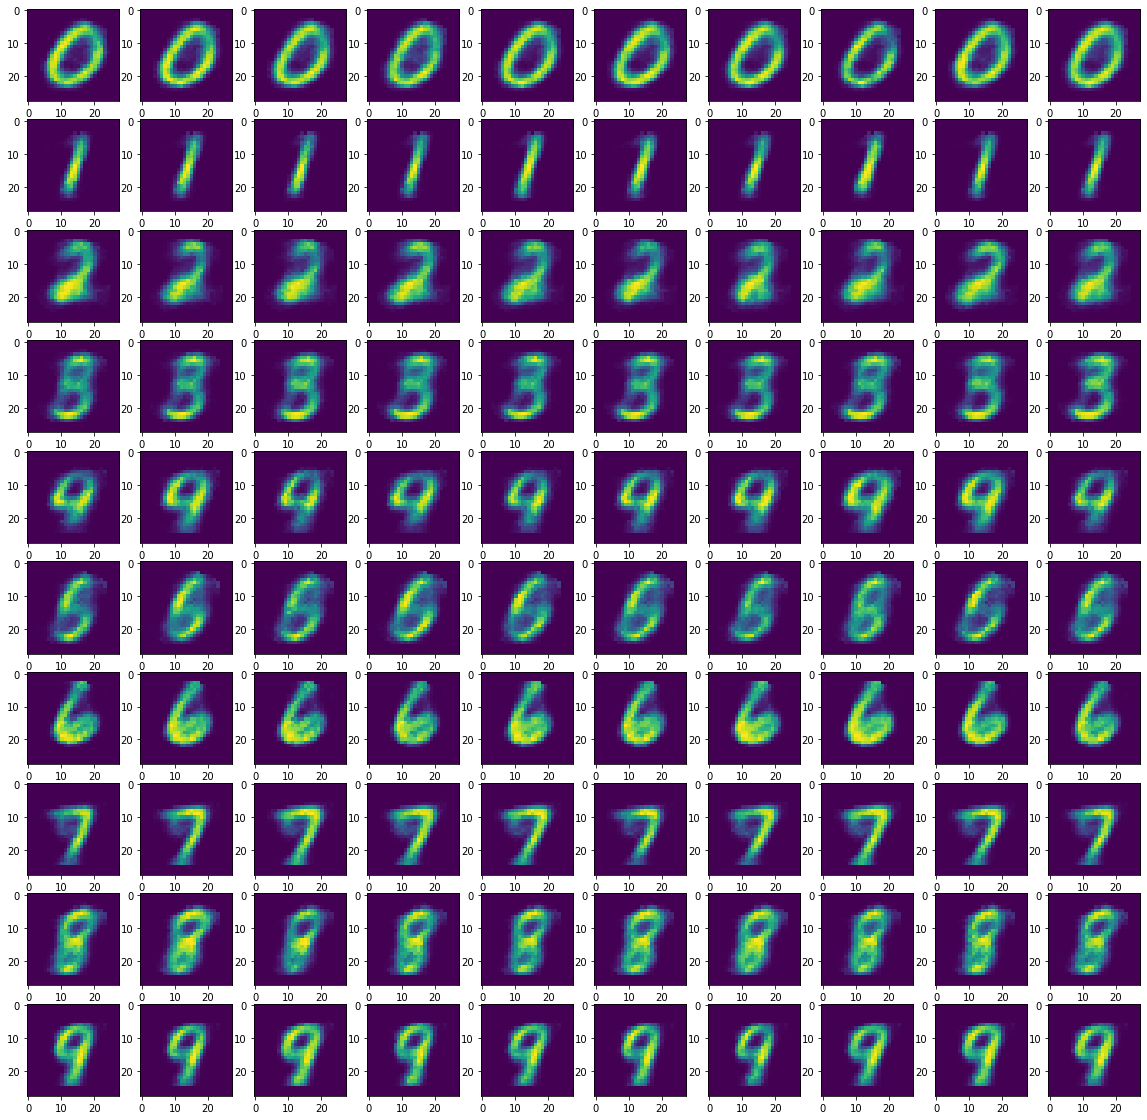

In [28]:
plt.rcParams['figure.figsize'] = [20, 20]
#gen_num = 2

ex_per_num = 10

fig, ax = plt.subplots(10,ex_per_num)

for gen_num in range(0,10):

    latent_shape = mean_latent_vectors[gen_num].shape
    ex_shape = np.concatenate(([ex_per_num], latent_shape))
    
    latent_noise = np.random.normal(size=ex_shape)
    #print(noise)
    #sample_latent_vector = mean_latent_vectors[gen_num] + latent_noise
    sample_latent_vector = np.zeros(ex_shape)
    for ex in range(len(sample_latent_vector)):
        sample_latent_vector[ex,:] = mean_latent_vectors[gen_num] + latent_noise[ex,:]
        
    ex_sample_images = net.decoder(torch.tensor(sample_latent_vector).to(device).float())
    
    for ex in range(len(sample_latent_vector)):
        ax[gen_num, ex].imshow(ex_sample_images[ex,:,:].detach().cpu().numpy()[0])

In [29]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

In [36]:
plt.rcParams['figure.figsize'] = [10, 10]

start = 0

mean_interact_kwargs = {}
for i in range(0,10):
    key = f"x{i}"
    #print(mean_latent_vectors.shape)
    mu = mean_latent_vectors[start][i]
    delta = 3.
    low = mu - delta
    high = mu + delta
    mean_interact_kwargs[key] = (low,high)

mean_interact_kwargs

sample_i = 0

sample_interact_kwargs = {}

for i in range(0,10):
    key = f"x{i}"
    print(latent_vectors.shape)
    mu = latent_vectors[start][sample_i][i]
    delta = 6.
    low = mu - delta
    high = mu + delta
    sample_interact_kwargs[key] = (low,high)
    
sample_interact_kwargs

(10, 100, 10)
(10, 100, 10)
(10, 100, 10)
(10, 100, 10)
(10, 100, 10)
(10, 100, 10)
(10, 100, 10)
(10, 100, 10)
(10, 100, 10)
(10, 100, 10)


{'x0': (-6.0, 6.0),
 'x1': (53.01047897338867, 65.01047897338867),
 'x2': (20.659099578857422, 32.65909957885742),
 'x3': (2.2169179916381836, 14.216917991638184),
 'x4': (-6.0, 6.0),
 'x5': (25.83714485168457, 37.83714485168457),
 'x6': (29.125953674316406, 41.125953674316406),
 'x7': (39.059696197509766, 51.059696197509766),
 'x8': (119.17462158203125, 131.17462158203125),
 'x9': (2.3250904083251953, 14.325090408325195)}

In [37]:
latent_vector = torch.zeros((latent_size)).to(device)

#@interact(x0=(-5.,5.), x1=(-5.,5.), x2=(-5.,5.), x3=(-5.,5.), x4=(-5.,5.), x5=(-5.,5.), x6=(-5.,5.), x7=(-5.,5.), x8=(-5.,5.), x9=(-5.,5.))
@interact(**sample_interact_kwargs)
#@interact(**mean_interact_kwargs)
#def update_latent_vector(x0=0., x1=0., x2=0., x3=0., x4=0., x5=0., x6=0., x7=0., x8=0., x9=0.):
def update_latent_vector(x0, x1, x2, x3, x4, x5, x6, x7, x8, x9):
    
    latent_vector[0] = x0
    latent_vector[1] = x1
    latent_vector[2] = x2
    latent_vector[3] = x3
    latent_vector[4] = x4
    latent_vector[5] = x5
    latent_vector[6] = x6
    latent_vector[7] = x7
    latent_vector[8] = x8
    latent_vector[9] = x9
    print(latent_vector)
    image = net.decoder(latent_vector).detach().cpu().numpy()[0][0]
    plt.imshow(image)

interactive(children=(FloatSlider(value=0.0, description='x0', max=6.0, min=-6.0), FloatSlider(value=59.010478…

In [32]:
print("mean latent vectors")
for i in range(0,10):
    print(f"number {i}")
    print(mean_latent_vectors[i])
    #print("std")
    #print(std_latent_vectors[i])

mean latent vectors
number 0
[0.00000000e+00 4.67543099e+01 2.04109255e+01 5.92770452e+00
 9.17793676e-02 2.45479528e+01 2.95703698e+01 3.78596564e+01
 9.68598895e+01 8.36940142e+00]
number 1
[0.00000000e+00 1.04374947e+02 2.36020453e+01 6.01506752e-02
 0.00000000e+00 3.53721156e+01 5.21758994e+01 2.53608553e+01
 1.19693306e+02 2.01051416e+01]
number 2
[0.00000000e+00 4.44436561e+01 1.85605951e+01 6.84071720e-01
 2.64577456e-03 1.73548935e+01 2.25149232e+01 2.87271000e+01
 6.51124137e+01 1.17223915e+01]
number 3
[ 0.         54.93856537 13.62342881  2.01132781  0.         17.96859877
 23.80493478 30.88493714 83.07569643  6.99409712]
number 4
[0.00000000e+00 6.37806084e+01 2.62730688e+01 6.15932426e-02
 1.00611267e-02 2.38063578e+01 5.48441810e+01 3.39796498e+01
 1.02195207e+02 9.19254011e+00]
number 5
[0.00000000e+00 5.29355261e+01 1.77348163e+01 2.48213086e+00
 5.14255241e-04 2.29406781e+01 3.02313426e+01 2.89586235e+01
 9.06839066e+01 8.39350170e+00]
number 6
[0.00000000e+00 7.833321

In [33]:
"""
def update_latent_vector(dummy):
    #index = 0
    latent_vector = torch.zeros((1,latent_size)).to(device)
    for i in range(0,latent_size):
        latent_vector[0,i] = sliders[i].value
        print(sliders[i].value)
    print(latent_vector)
    image = net.decoder(latent_vector.float()).detach().cpu().numpy()[0][0]
    #print(image.shape)
    #clear_output
    plt.clf()
    #plt.close()
    plt.imshow(image)
    #clear_output


sliders = []
for i in range(0,latent_size):
    sliders.append(widgets.FloatSlider(min=-2., max=2.))
    display(sliders[i])
"""

'\ndef update_latent_vector(dummy):\n    #index = 0\n    latent_vector = torch.zeros((1,latent_size)).to(device)\n    for i in range(0,latent_size):\n        latent_vector[0,i] = sliders[i].value\n        print(sliders[i].value)\n    print(latent_vector)\n    image = net.decoder(latent_vector.float()).detach().cpu().numpy()[0][0]\n    #print(image.shape)\n    #clear_output\n    plt.clf()\n    #plt.close()\n    plt.imshow(image)\n    #clear_output\n\n\nsliders = []\nfor i in range(0,latent_size):\n    sliders.append(widgets.FloatSlider(min=-2., max=2.))\n    display(sliders[i])\n'

In [34]:
"""
for i in range(0,latent_size):
    sliders[i].observe(update_latent_vector, names=["value"])
    """

'\nfor i in range(0,latent_size):\n    sliders[i].observe(update_latent_vector, names=["value"])\n    '

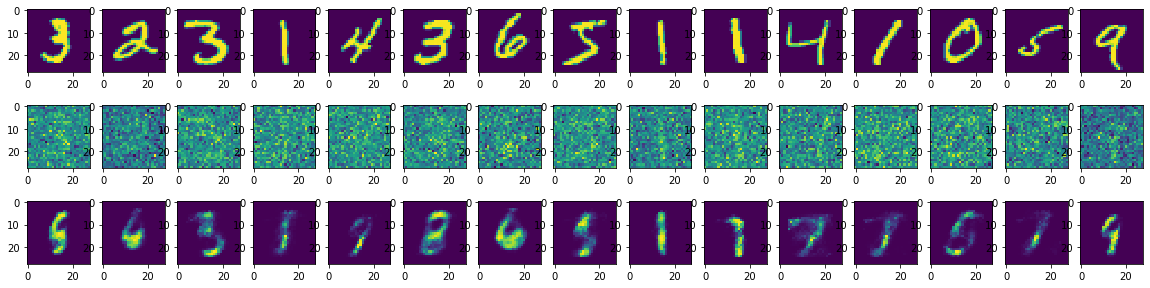

In [38]:
"""Denoising images"""

plt.rcParams['figure.figsize'] = [20, 5]
test_image, test_label = dataset[0]
indices = np.arange(0,15)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices)
noise_scale = 1.0
noise_func = torch.randn
noise_kwargs = {}

"""
dataset.transform = torchvision.transforms.Compose([
                #torchvision.transforms.ToTensor(),
                dataset_class_gsimage.min_max_scaler(device=device),
                dataset_class_gsimage.add_normal_noise(0.,0.1,device=device),
            ])
"""

dataset.transform = torchvision.transforms.Compose([
                dataset_class_gsimage.min_max_scaler(device=device),
            ])

#dataset.transform = None

train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=test_sampler)
test_images = []
noisy_images = []
outputs = []
for test_batch in train_loader:
    test_image = test_batch[0].to(device)
    test_images.append(test_image)
    noise_kwargs["size"] = test_image.size()
    noise = noise_scale * noise_func(**noise_kwargs).to(device)
    noisy_image = test_image + noise
    noisy_images.append(noisy_image)
    #plt.imshow(test_image.cpu()[0,0])
    net.eval()
    output = net.forward(noisy_image.float())
    outputs.append(output)

num_images = len(outputs)
fig, ax = plt.subplots(3,num_images)
for image_i in range(num_images):
    ax[0, image_i].imshow(test_images[image_i].cpu()[0,0])
    ax[1, image_i].imshow(noisy_images[image_i].detach().cpu()[0,0])
    ax[2, image_i].imshow(outputs[image_i].detach().cpu()[0,0])